In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
import importlib

from __init__ import *
from __init__jupyterlab import *


import collections
from collections import deque
from scipy import stats
from scipy import optimize 
from scipy.optimize import curve_fit

import queue
# import tables
from scipy import sparse
from sklearn.model_selection import KFold
from sklearn.metrics import adjusted_rand_score
# from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors
# from sklearn.utils.sparsefuncs import mean_variance_axis
import fbpca
from statsmodels.stats.multitest import multipletests


import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)

# from CEMBA_run_tsne import run_tsne
# from CEMBA_run_tsne import run_tsne_v2

<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

## Basic settings 
- use ```mods``` and ```settings[mod]``` to access modality specific information

In [2]:
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells_v2', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    ]

In [3]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [4]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
snatac_gene (54844, 13)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129)
smarter_nuclei (5911, 146)
10x_cells_v2 (121440, 8)
10x_cells_v3 (69727, 8)
10x_nuclei_v3 (39706, 8)
10x_nuclei_v3_macosko (101647, 19)


In [5]:
# gxc_hvftrs = collections.OrderedDict()
# for mod in mods_selected:
#     print(mod)
#     ti = time.time()
    
#     if settings[mod].mod_category == 'mc':
#         f_mat = hvftrs_f.format(mod, 'tsv')
#         gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
# #         gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
#         print(gxc_hvftrs[mod].shape, time.time()-ti)
#         assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
#         continue
        
        
#     f_mat = hvftrs_f.format(mod, 'npz')
#     f_gene = hvftrs_gene.format(mod)
#     f_cell = hvftrs_cell.format(mod)
#     _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
#     _gene = _gxc_tmp.gene
#     _cell = _gxc_tmp.cell
#     _mat = _gxc_tmp.data

# #     _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
# #     ## remove duplicated genes (for now)
# #     u, c = np.unique(_gene, return_counts=True)
# #     dup = u[c > 1]
# #     uniq_bool = np.array([False if gene in dup else True for gene in _gene])
# #     _gene_selected = _gene[uniq_bool]
# #     _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
# #     _gene = _gene_selected
# #     _mat = _mat.tocsr()[_gene_selected_idx, :]
# #     ## remove duplicated genes complete
    
#     gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
#     assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
#     print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

In [6]:
for mod in mods_selected:
    _x = metas[mod]
    n = len(_x[_x[settings[mod].cluster_col]!=-1])
    print(mod, n)

n_subs_allmods = collections.OrderedDict({
    'snmcseq_gene': (np.array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9366])).astype(int), 
    'snatac_gene': (np.array([1000, 2000, 5000, 10000, 20000, 40000, 54844])).astype(int), 
    'smarter_cells': (np.array([1000, 2000, 3000, 4000, 5000, 6000, 6244])).astype(int), 
    'smarter_nuclei': (np.array([1000, 2000, 3000, 4000, 5000, 5911])).astype(int), 
    '10x_cells_v2': (np.array([1000, 2000, 5000, 10000, 20000, 
                            30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 121440])).astype(int), 
    '10x_cells_v3': (np.array([1000, 2000, 5000, 10000, 20000, 
                            30000, 40000, 50000, 60000, 69727])).astype(int), 
    '10x_nuclei_v3': (np.array([1000, 2000, 5000, 10000, 20000, 
                            30000, 39706])).astype(int), 
    '10x_nuclei_v3_macosko': (np.array([1000, 2000, 5000, 10000, 20000, 
                            30000, 40000, 50000, 60000, 70000, 80000, 90000, 101647])).astype(int), 
})

n_subs_allmods

snmcseq_gene 9366
snatac_gene 54844
smarter_cells 6244
smarter_nuclei 5911
10x_cells_v2 121440
10x_cells_v3 69727
10x_nuclei_v3 39706
10x_nuclei_v3_macosko 101647


OrderedDict([('snmcseq_gene',
              array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9366])),
             ('snatac_gene',
              array([ 1000,  2000,  5000, 10000, 20000, 40000, 54844])),
             ('smarter_cells',
              array([1000, 2000, 3000, 4000, 5000, 6000, 6244])),
             ('smarter_nuclei', array([1000, 2000, 3000, 4000, 5000, 5911])),
             ('10x_cells_v2',
              array([  1000,   2000,   5000,  10000,  20000,  30000,  40000,  50000,
                      60000,  70000,  80000,  90000, 100000, 110000, 121440])),
             ('10x_cells_v3',
              array([ 1000,  2000,  5000, 10000, 20000, 30000, 40000, 50000, 60000, 69727])),
             ('10x_nuclei_v3',
              array([ 1000,  2000,  5000, 10000, 20000, 30000, 39706])),
             ('10x_nuclei_v3_macosko',
              array([  1000,   2000,   5000,  10000,  20000,  30000,  40000,  50000,
                      60000,  70000,  80000,  90000, 101647]))])

In [7]:
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'
f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

# back compatible
# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

In [8]:
settings

OrderedDict([('snmcseq_gene',
              Mod_info(mod='snmcseq_gene', name='DNA methylation', mod_category='mc', norm_option='mc', mod_direction=-1, cell_col='cell', cluster_col='SubCluster', annot_col='SubCluster', category_col='SubCluster', global_mean='CH_Rate', global_mean_mcg='CG_Rate', total_reads='FinalReads', color='#6DC8BF', species='mouse')),
             ('snatac_gene',
              Mod_info(mod='snatac_gene', name='Open chromatin', mod_category='atac', norm_option='tpm', mod_direction=1, cell_col='cell', cluster_col='cluster', annot_col='cluster', category_col='cluster', global_mean='', global_mean_mcg='', total_reads='', color='#00ADDC', species='mouse')),
             ('smarter_cells',
              Mod_info(mod='smarter_cells', name='scRNA SMART', mod_category='rna', norm_option='tpm', mod_direction=1, cell_col='cell', cluster_col='cluster_id', annot_col='cluster_label', category_col='cell_class', global_mean='', global_mean_mcg='', total_reads='', color='#FF3333', s

## Plots

### Visualization 1 
- Number of clusters

In [9]:
res = [] 
mod_rvals = {}
mod_n_subs = {}
mod_ridxs = {}
mod_nidxs = {}

# prefix_format = '/cndd/fangming/CEMBA/results_neuron/190723/clst_neuron_leiden_downsamp_{0}_'
prefix_format = '/cndd/fangming/CEMBA/results_neuron/clst_neuron_leiden_downsamp_{0}_'


# select modality, number of cells, resolution, repeats, versions
for mod in mods_selected:
    files = natsorted(glob.glob(prefix_format.format(mod)+'[0-9]*_*_*_190723.tsv'))
    print(len(files))
    rvals = set()
    n_subs = set()
    
    for file in files:
        prefix = prefix_format.format(mod)
        if len(file[len(prefix):].split('_')) != 4:
            print(file)
            print(file[len(prefix):].split('_'))
        
        n_sub, rval, _repeat, _version = file[len(prefix):].split('_')
        
        n_sub = int(n_sub)
        n_subs.add(n_sub)
        rval = int(rval)
        rvals.add(rval)

        df_clst = pd.read_csv(file, sep='\t', index_col=0)
        if mod != 'integrated':
            y_pred = metas[mod].loc[df_clst.index, settings[mod].cluster_col].values
            y = df_clst['cluster'].values
            ari = adjusted_rand_score(y_pred, y)
        else:
            ari = 0
        
        nclst = len(df_clst['cluster'].unique())
        res.append({'mod': mod, 'rval': rval, 'n_sub': n_sub, 
                    'n_repeat': _repeat,
                    'nclst': nclst, 
#                     'clsts': df_clst, 
                    'ari': ari,})
        
    rvals = np.sort(list(rvals))
    ridxs = np.arange(len(rvals))

    n_subs = np.sort(list(n_subs))
    nidxs = np.arange(len(n_subs))
    
    mod_rvals[mod] = rvals
    mod_n_subs[mod] = n_subs
    mod_ridxs[mod] = ridxs
    mod_nidxs[mod] = nidxs
    
res = pd.DataFrame(res)
res.head()

540
420
420
360
900
600
420
780


,ari,mod,n_repeat,n_sub,nclst,rval
0,0.532498,snmcseq_gene,0,1000,11,1
1,0.553034,snmcseq_gene,1,1000,12,1
2,0.647779,snmcseq_gene,2,1000,11,1
3,0.543437,snmcseq_gene,3,1000,12,1
4,0.716286,snmcseq_gene,4,1000,11,1


In [10]:
# fout = '/cndd/fangming/CEMBA/results_neuron/summaries/summary_8mods_191009.tsv'
fout = '/cndd/fangming/CEMBA/results_neuron/summaries/summary_8mods_191218.tsv'
res.to_csv(fout, sep='\t', header=True, index=False)

In [11]:
res1 = res.set_index(['mod', 'n_sub', 'rval'])

print(mod_rvals)
res1.head()

{'snmcseq_gene': array([1, 2, 3, 4, 6, 8]), 'snatac_gene': array([1, 2, 3, 4, 6, 8]), 'smarter_cells': array([1, 2, 3, 4, 6, 8]), 'smarter_nuclei': array([1, 2, 3, 4, 6, 8]), '10x_cells_v2': array([1, 2, 3, 4, 6, 8]), '10x_cells_v3': array([1, 2, 3, 4, 6, 8]), '10x_nuclei_v3': array([1, 2, 3, 4, 6, 8]), '10x_nuclei_v3_macosko': array([1, 2, 3, 4, 6, 8])}


ari n_repeat  nclst
mod          n_sub rval                          
snmcseq_gene 1000  1     0.532498        0     11
                   1     0.553034        1     12
                   1     0.647779        2     11
                   1     0.543437        3     12
                   1     0.716286        4     11

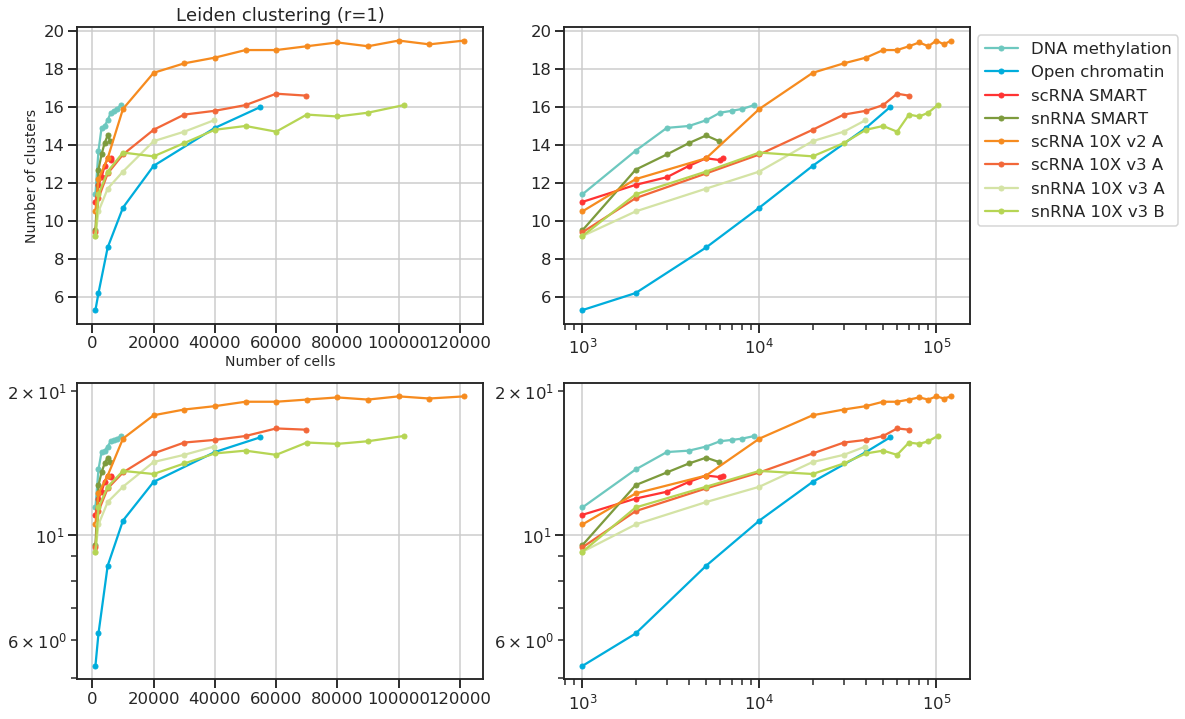

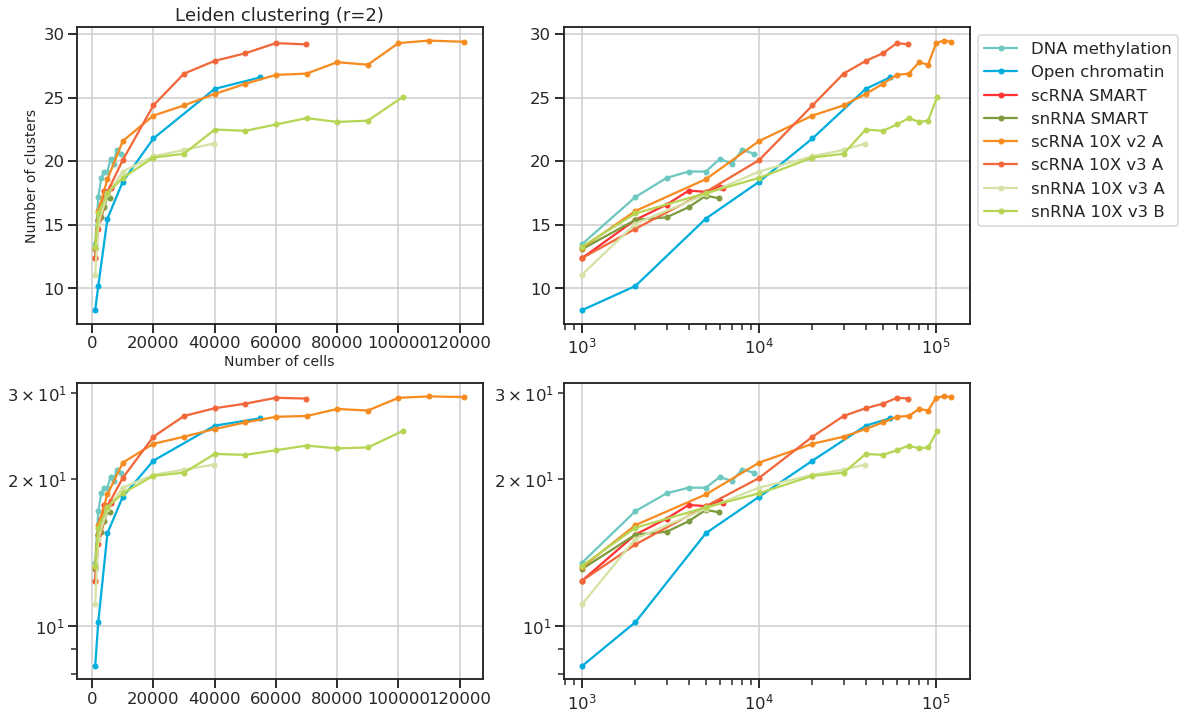

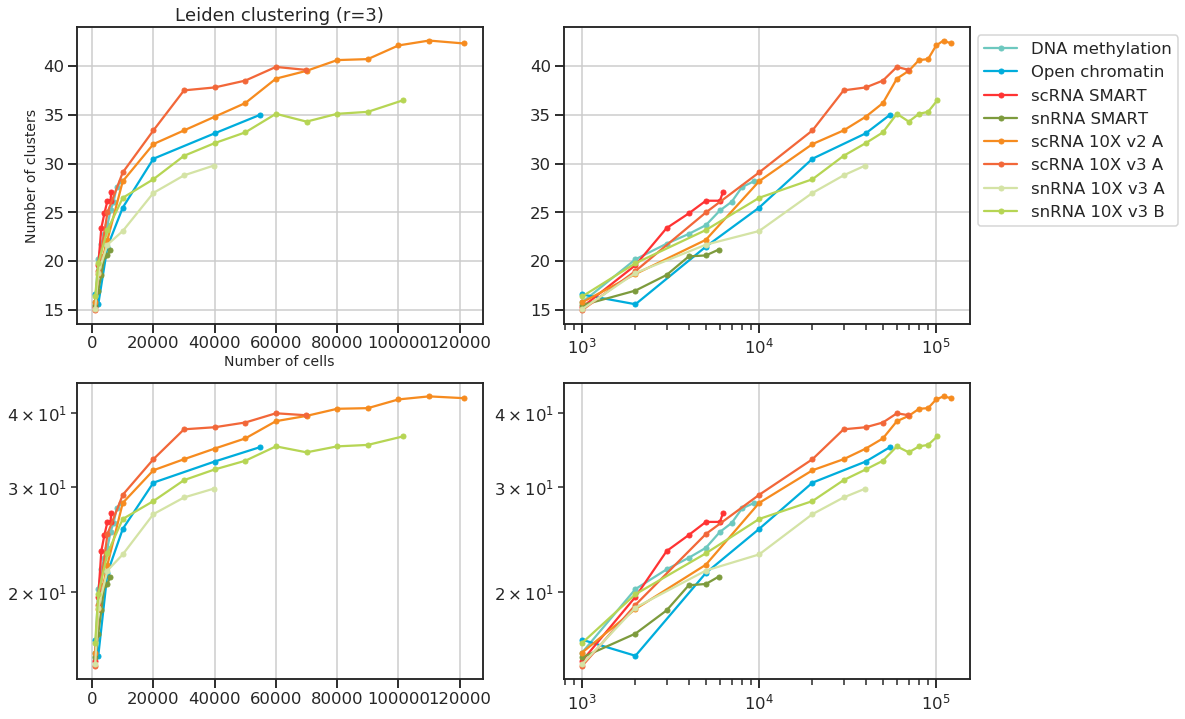

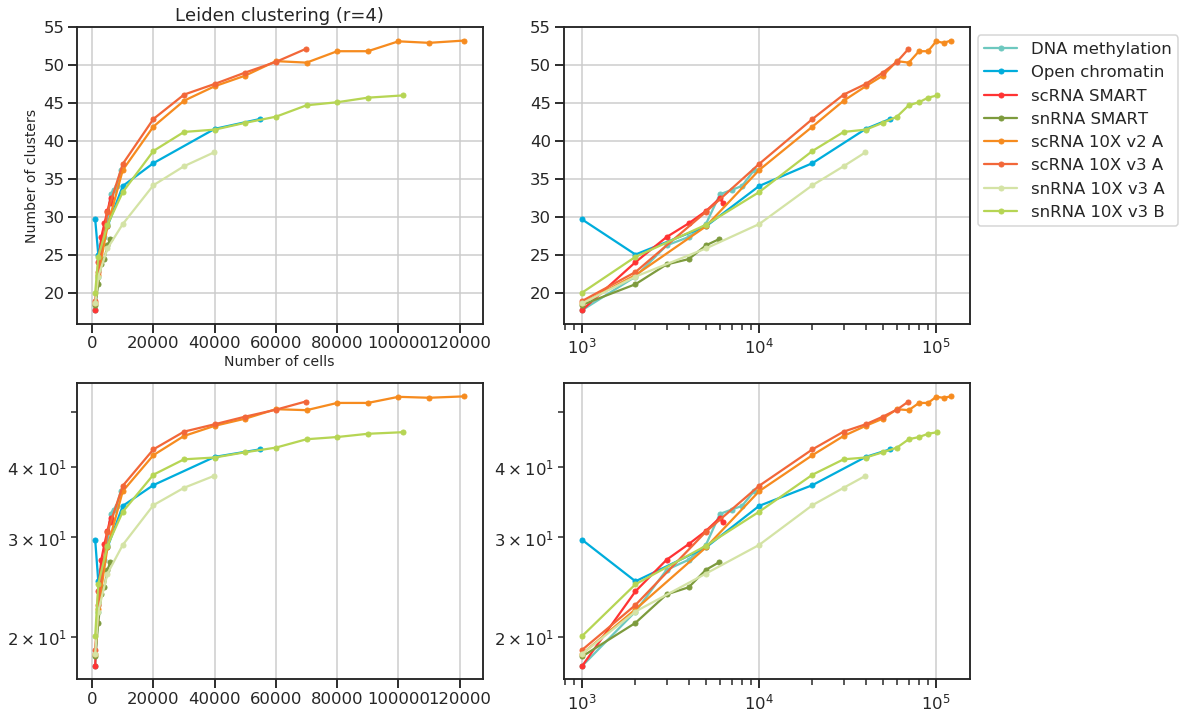

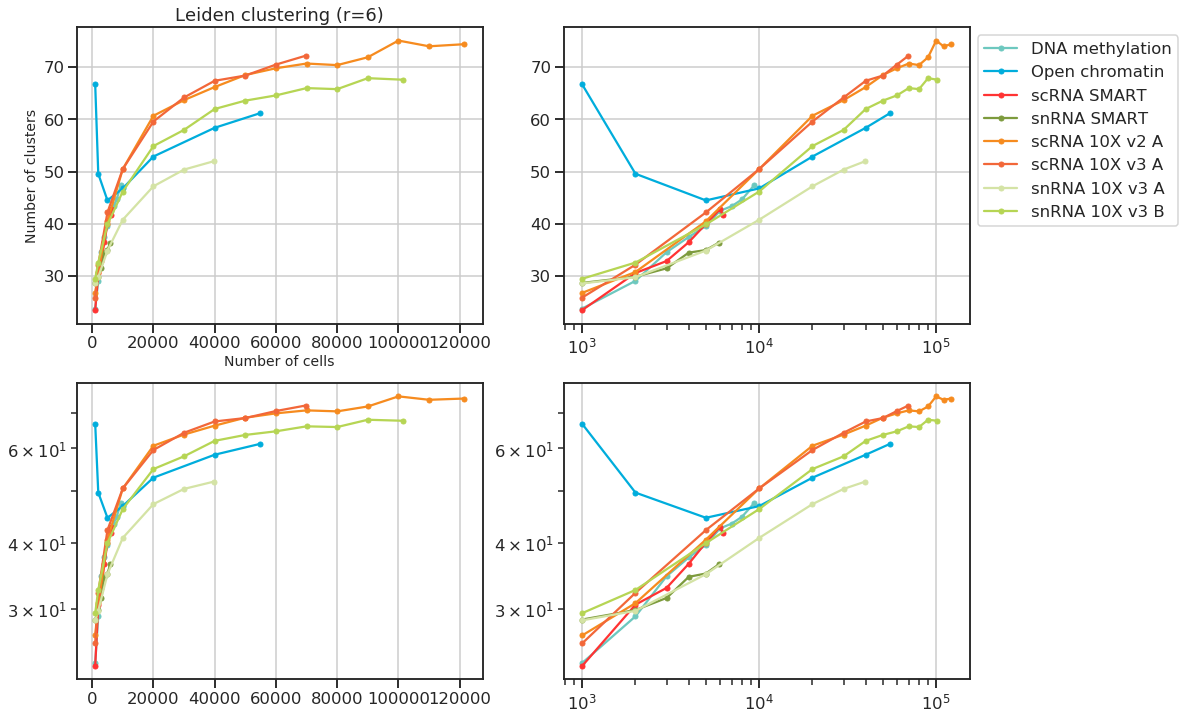

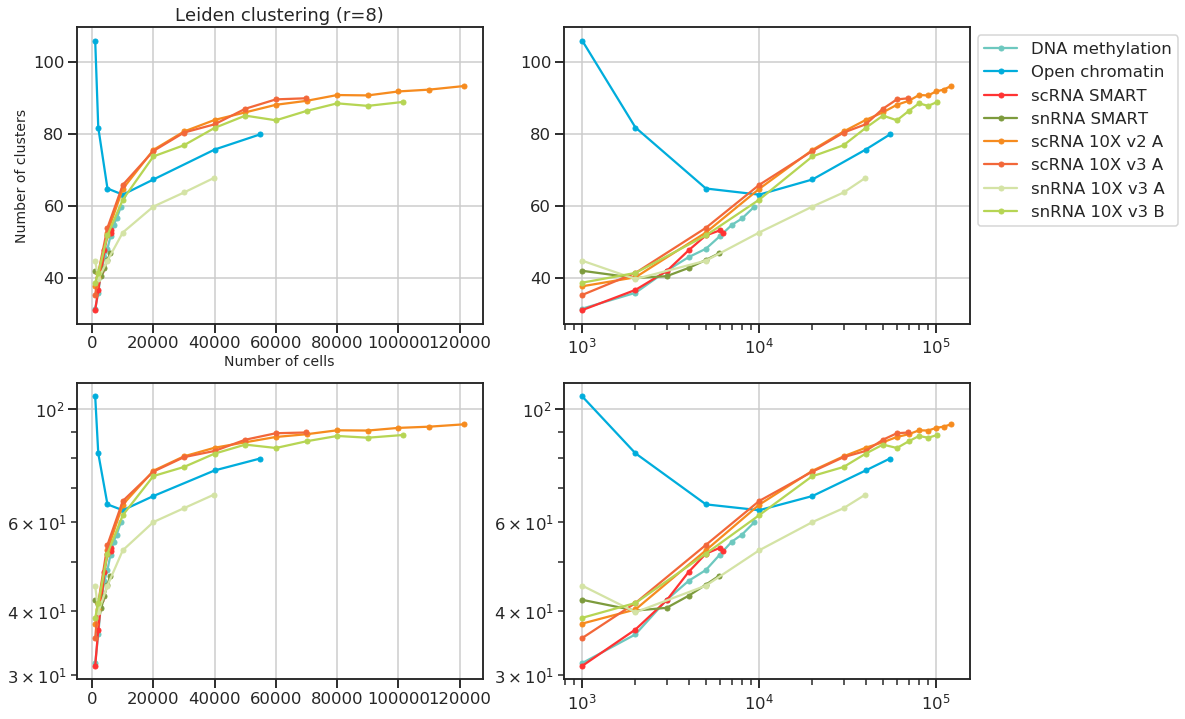

In [22]:
rvals = mod_rvals[mods_selected[0]] 
n_repeats = 5

for rval in rvals: 
    mods_used = mods_selected
    fig, axs = plt.subplots(2, 2, figsize=(8*2,6*2))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        _tmp = []
        for mod in mods_used:
            if mod == 'integrated':
                label = 'Integrated' 
                color = 'C6' 
            else:
                label = '{}'.format(settings[mod].name)
                color = settings[mod].color
                
            _x = res1.loc[mod, :, rval]['nclst'].reset_index().groupby('n_sub').agg(['mean', 'std'])
            x = _x.index.values
            y = _x['nclst','mean'].values
            yerr = 1.96*_x['nclst', 'std'].values/np.sqrt(n_repeats)
            ax.plot(x, y, '-o', label=label, color=color, markersize=5)
#             ax.fill_between(x, y-yerr, y+yerr, color=color, alpha=0.5)
#             ax.errorbar(x, y, yerr=yerr, 
#                         label=label, 
#                         color=color,
#                         markersize=5,
#                         fmt='-o', 
#                         capsize=3,
#                        )
#             _tmp += _x['nclst', 'mean'].iloc[_x.index.values<11000].values.tolist()
        #### end for mods (each line)
        if i == 1:
            ax.set_xscale('log')
        if i == 2:
            ax.set_yscale('log')
        if i == 3:
            ax.set_xscale('log')
            ax.set_yscale('log')
            
#             ax.set_xlim([500, 11000]) 
#             ymin, ymax, yrange = min(_tmp), max(_tmp), max(_tmp) - min(_tmp)
#             ymin, ymax = min(_tmp) - 0.1*yrange, max(_tmp) + 0.1*yrange
#             ax.set_ylim([ymin, ymax]) 
        
    #### end for ax
    ax = axs[0]
    ax.set_ylabel('Number of clusters', fontsize=14)
    ax.set_xlabel('Number of cells', fontsize=14)
    ax.set_title("Leiden clustering (r={})".format(rval))
    
    ax = axs[1]
    ax.legend(bbox_to_anchor=(1,1)) 
    
#     break
        
#     fig.tight_layout()
#     output = '/cndd/fangming/CEMBA/results_neuron/summaries/fig_8mods_191009_r{}.pdf'.format(rval)
    output = '/cndd/fangming/CEMBA/results_neuron/summaries/fig_8mods_191218_r{}.pdf'.format(rval)
    fig.savefig(output, bbox_inches='tight')
    plt.show()


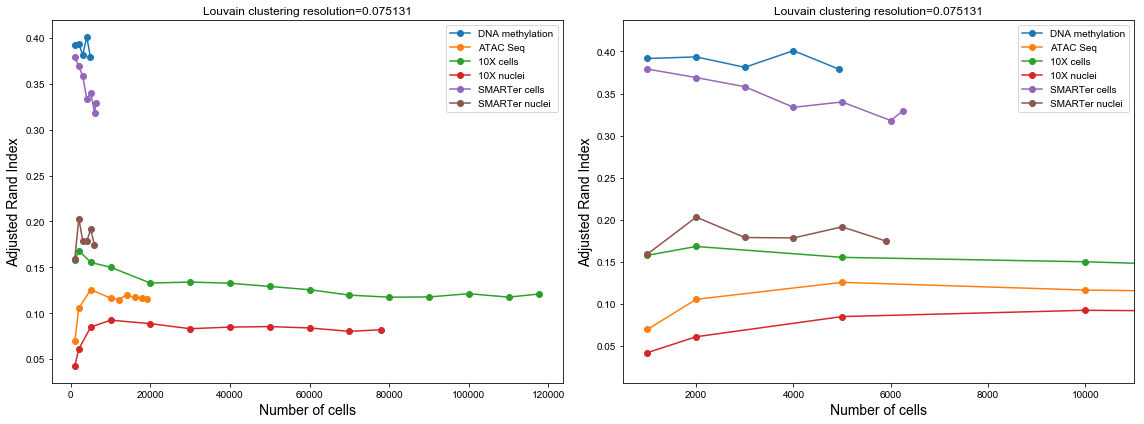

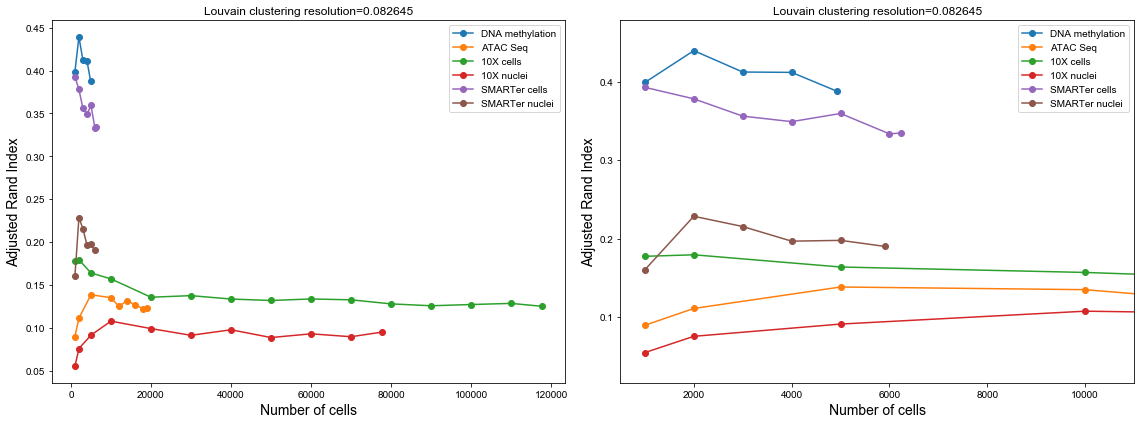

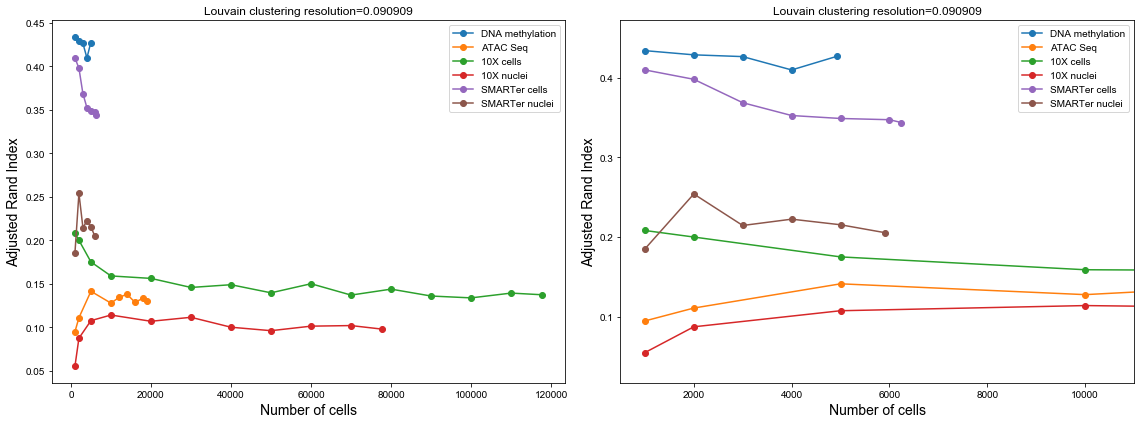

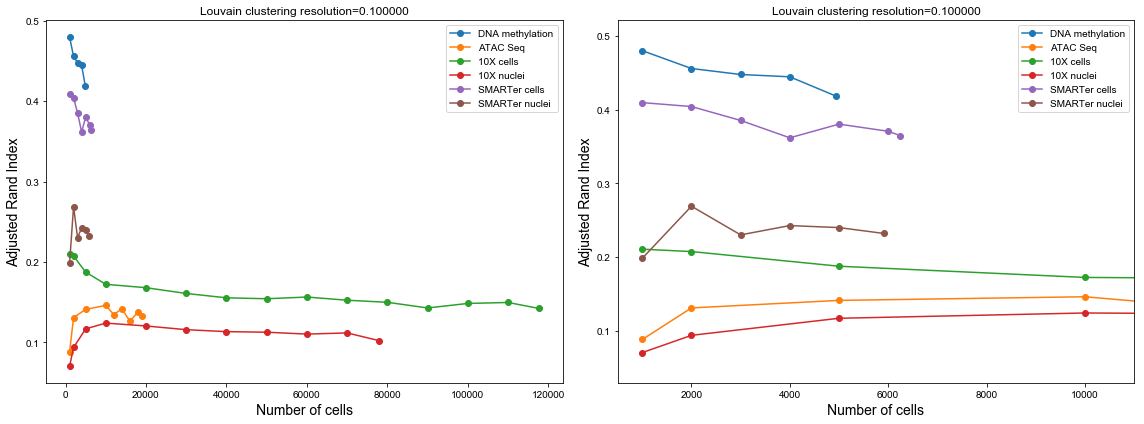

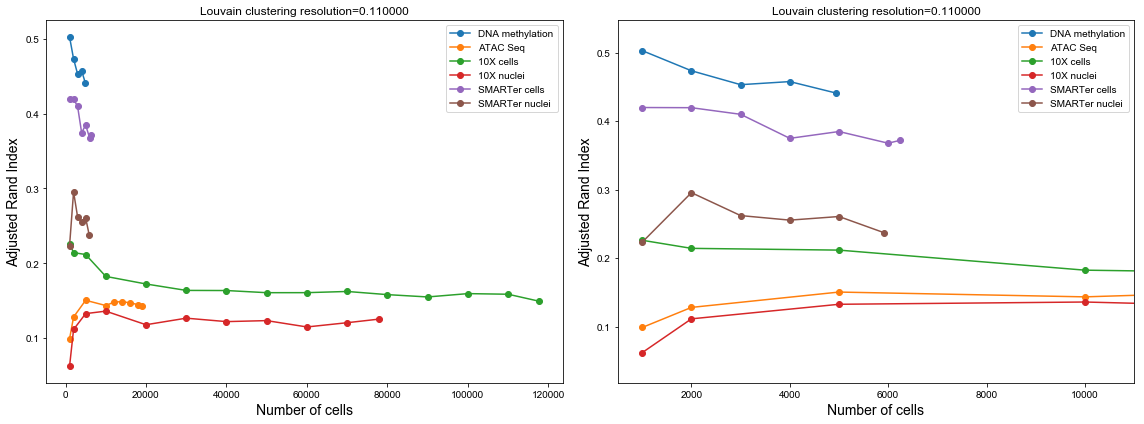

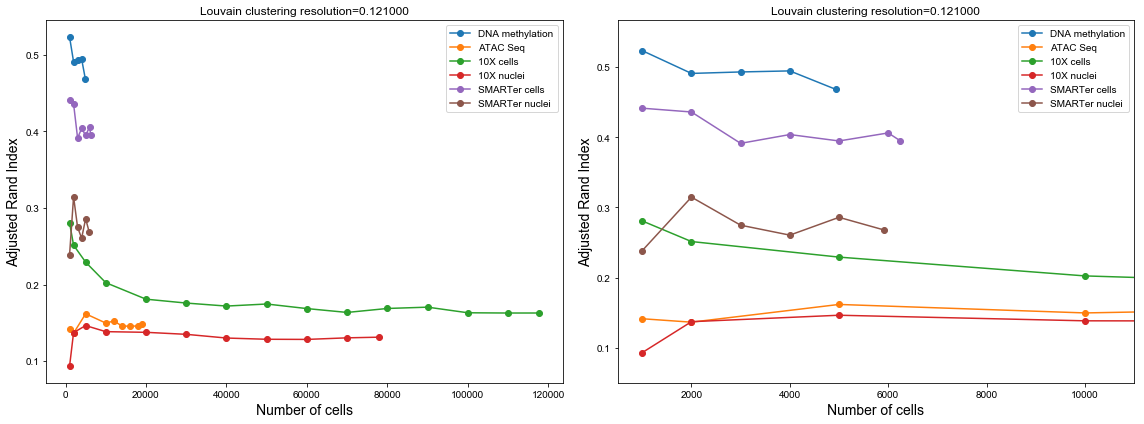

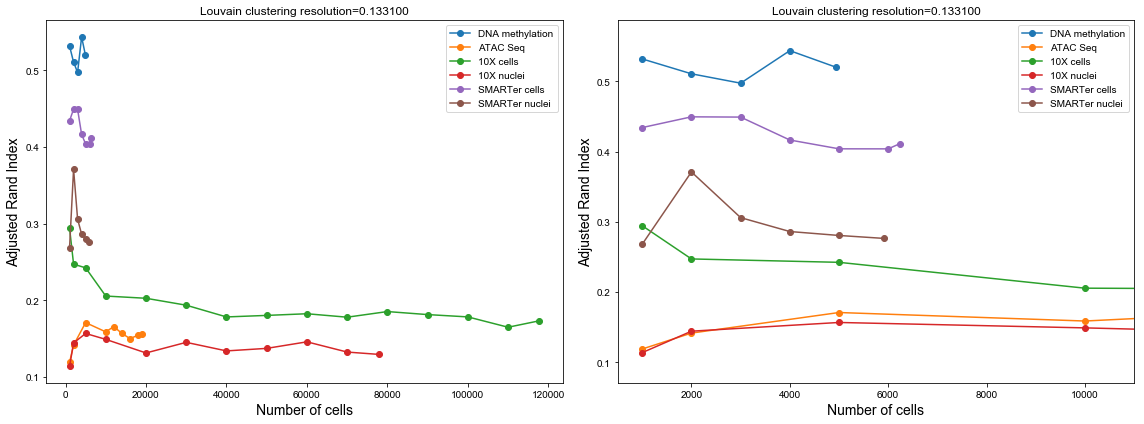

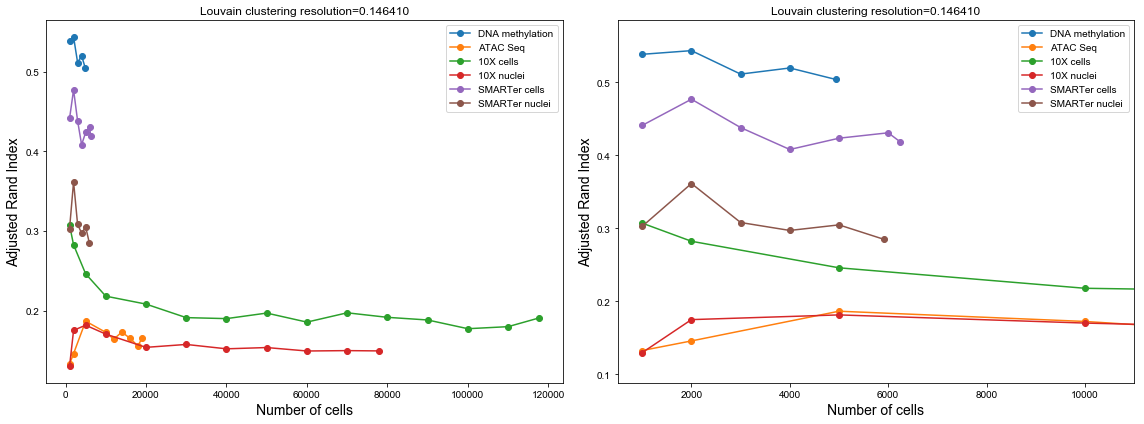

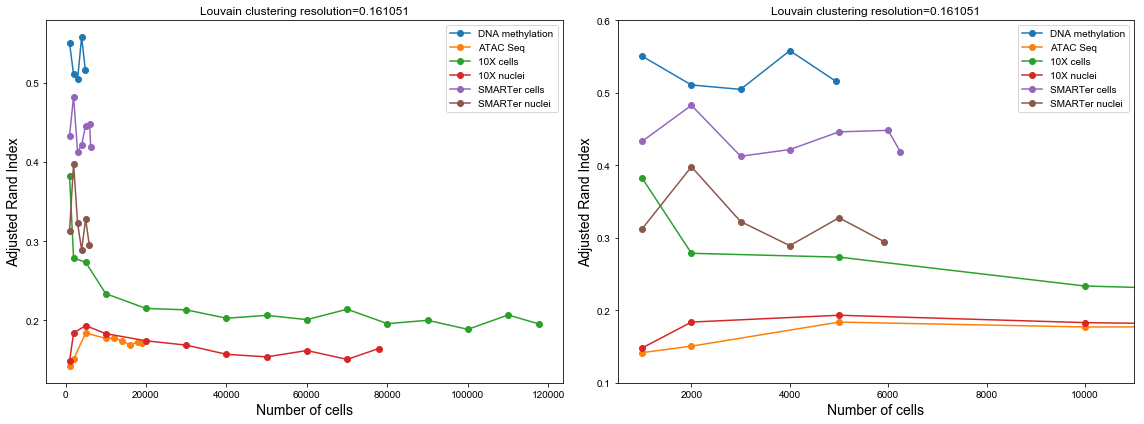

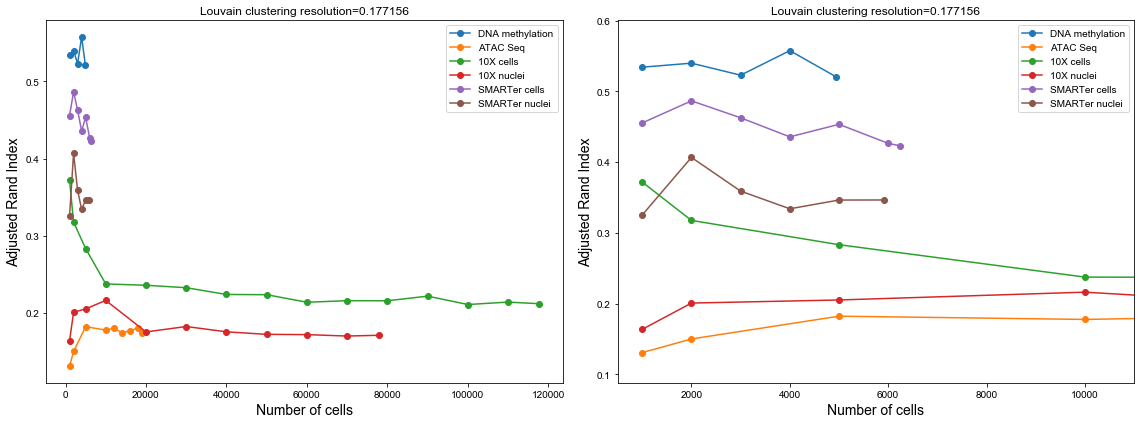

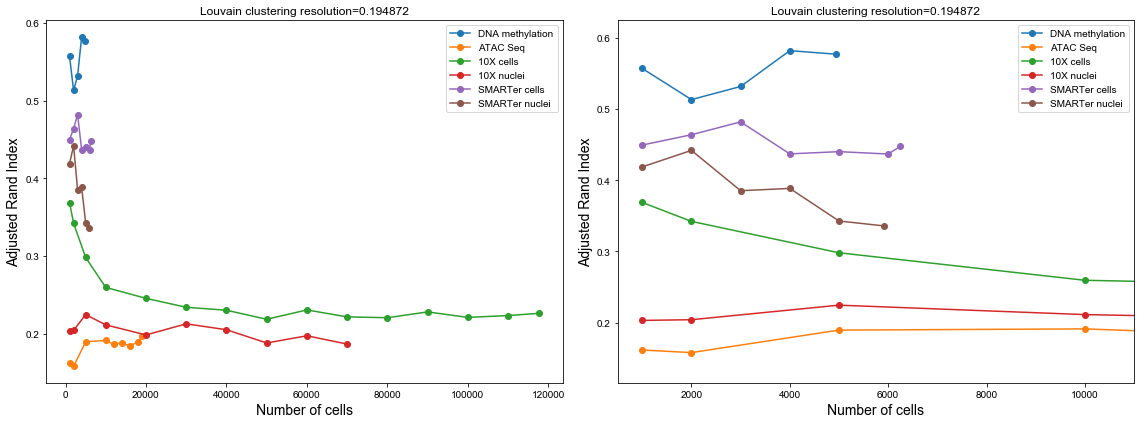

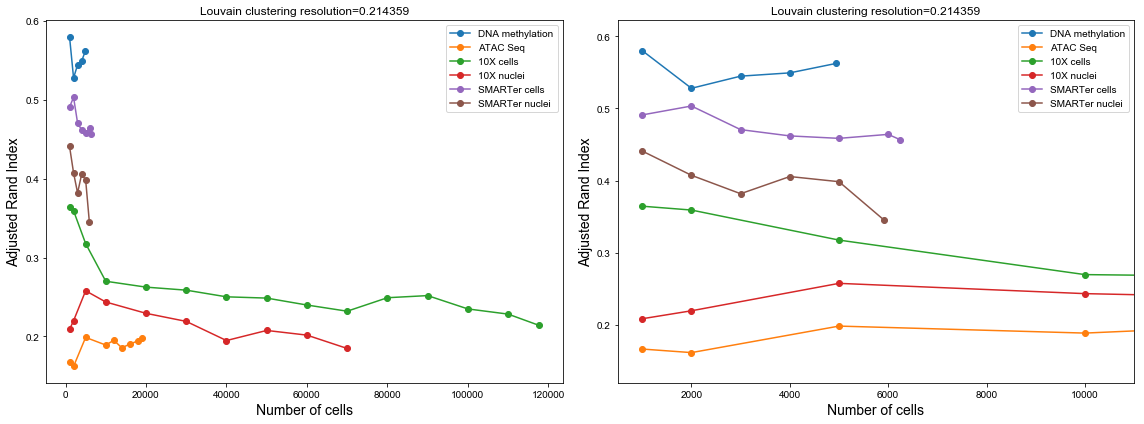

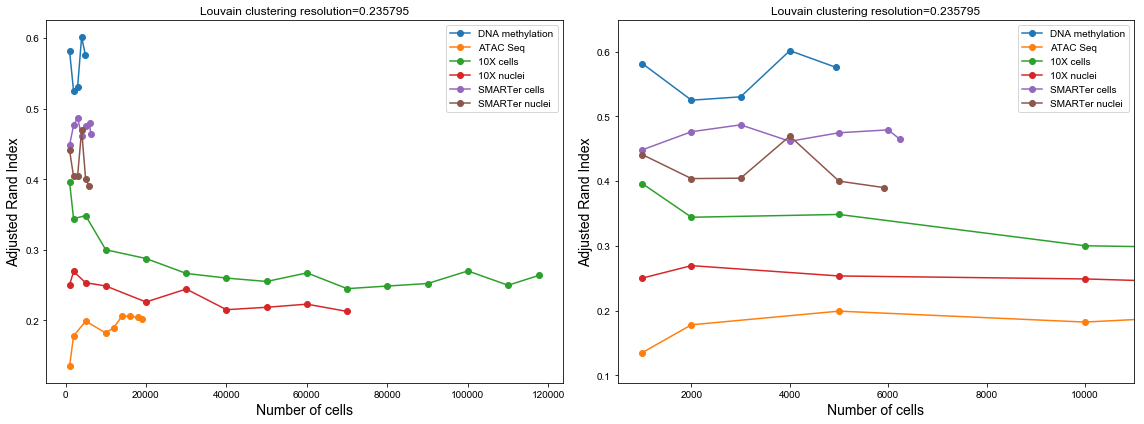

In [9]:
# rvals = mod_rvals['10x_cells']
# # rval = 'k30'
# for rval in rvals: 
#     # mods_used = ['snmcseq_gene', 'snatac_gene', '10x_cells', ]
#     mods_used = mods

#     fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
#     for i, ax in enumerate(axs):
#         _tmp = []
#         for mod in mods_used:
#             _x = res1.loc[mod, :, rval]['ari']
#             ax.plot(_x.index.values, _x.values, '-o', 
#                     label='{}'.format(settings[mod].name), 
#                     color=settings[mod].color)
#             _tmp += _x.iloc[_x.index.values<11000].values.tolist()

#             ax.legend() 
#         #     ax.set_xscale('log')
#         #     ax.set_yscale('log')
#             ax.set_xlabel('Number of cells', fontsize=14)
#             ax.set_ylabel('Adjusted Rand Index', fontsize=14)
#             ax.set_title("Louvain clustering resolution={}".format(rval))

#         if i == 1:
#             ax.set_xlim([500, 11000]) 
#             ymin, ymax, yrange = min(_tmp), max(_tmp), max(_tmp) - min(_tmp)
#             ymin, ymax = min(_tmp) - 0.1*yrange, max(_tmp) + 0.1*yrange
#             ax.set_ylim([ymin, ymax]) 
#     #         ax.set_ylim([15, 40]) 
#     fig.tight_layout()
#     plt.show()


### Visualization 2 

In [19]:
res = [] 
mod_rvals = {}
mod_n_subs = {}
mod_ridxs = {}
mod_nidxs = {}

mods = ['snmcseq_gene', 'snatac_gene', '10x_cells', '10x_nuclei', 'smarter_cells', 'smarter_nuclei']
prefix_format = '/cndd/fangming/CEMBA/results/clst_louvain_downsamp_{0}_'
#     files = natsorted(glob.glob('/cndd/fangming/CEMBA/results/clst_louvain_downsamp_{}_*_r*_0_v0'.format(mod)))
#     files = natsorted(glob.glob('/cndd/fangming/CEMBA/results/clst_louvain_downsamp_{}_*_*_0_v1'.format(mod)))

for mod in mods:
    files = natsorted(glob.glob(prefix_format.format(mod)+'*_r*_0_v0'))
    files = [file for file in files if 'rlog10' not in file]
    rvals = set()
    n_subs = set()

    for file in files:
        prefix = prefix_format.format(mod)
        n_sub, rval, _repeat, _version = file[len(prefix):].split('_')
        n_sub = int(n_sub)
        n_subs.add(n_sub)
        rval = rval[1:] ### new
        rvals.add(rval)

        df_clst = pd.read_csv(file, sep='\t', index_col=0)
        y_pred = metas[mod].loc[df_clst.index, settings[mod].cluster_col].values
        y = df_clst['cluster'].values
        ari = adjusted_rand_score(y_pred, y)
        nclst = len(df_clst['cluster'].unique())
        res.append({'mod': mod, 'rval': rval, 'n_sub': n_sub, 
                    'nclst': nclst, 'clsts': df_clst, 'ari': ari,})
        
    rvals = np.sort(list(rvals))
    ridxs = np.arange(len(rvals))

    n_subs = np.sort(list(n_subs))
    nidxs = np.arange(len(n_subs))
    
    mod_rvals[mod] = rvals
    mod_n_subs[mod] = n_subs
    mod_ridxs[mod] = ridxs
    mod_nidxs[mod] = nidxs
res = pd.DataFrame(res)
res.head()

,ari,clsts,mod,n_sub,nclst,rval
0,0.453560,...,snmcseq_gene,1000,41,0.1
1,0.000000,...,snmcseq_gene,1000,1000,0.01
2,0.485409,...,snmcseq_gene,1000,13,0.5
3,0.295355,...,snmcseq_gene,1000,235,0.05
4,0.496088,...,snmcseq_gene,1000,13,1


In [20]:
res1 = res.set_index(['mod', 'n_sub', 'rval'])
print(mod_rvals)
res1.head()

{'snmcseq_gene': array(['0.01', '0.05', '0.1', '0.5', '1'], dtype='<U4'), 'snatac_gene': array(['0.01', '0.05', '0.1', '0.5', '1'], dtype='<U4'), '10x_cells': array(['0.01', '0.05', '0.1', '0.2', '0.30000000000000004',
       '0.4000000000000001', '0.5', '0.5000000000000001',
       '0.6000000000000001', '1'], dtype='<U19'), '10x_nuclei': array(['0.01', '0.05', '0.1', '0.5', '1'], dtype='<U4'), 'smarter_cells': array(['0.01', '0.05', '0.1', '0.5', '1'], dtype='<U4'), 'smarter_nuclei': array(['0.01', '0.05', '0.1', '0.5', '1'], dtype='<U4')}


ari  \
mod          n_sub rval             
snmcseq_gene 1000  0.1   0.453560   
                   0.01  0.000000   
                   0.5   0.485409   
                   0.05  0.295355   
                   1     0.496088   

                                                                     clsts  \
mod          n_sub rval                                                      
snmcseq_gene 1000  0.1                                                 ...   
                   0.01                                                ...   
                   0.5                                                 ...   
                   0.05                                                ...   
                   1                                                   ...   

                         nclst  
mod          n_sub rval         
snmcseq_gene 1000  0.1      41  
                   0.01   1000  
                   0.5      13  
                   0.05    235  
                   1        13

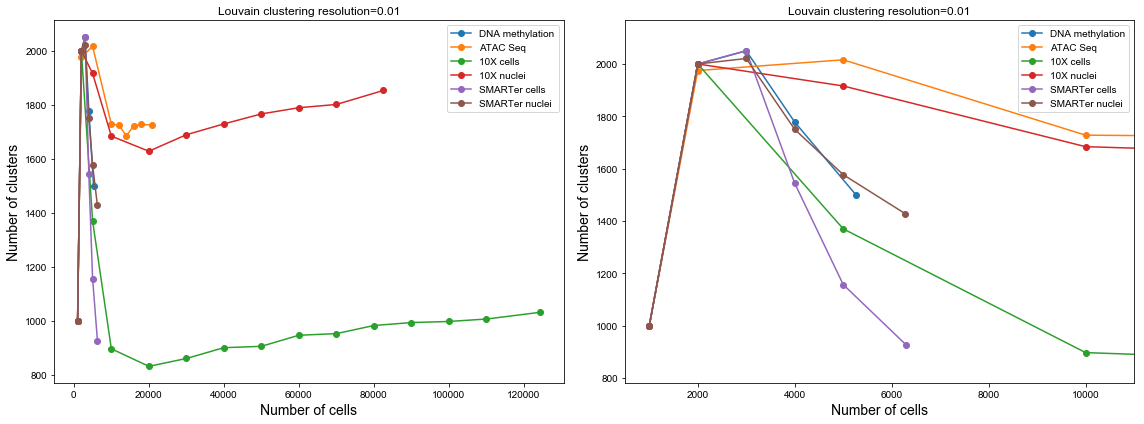

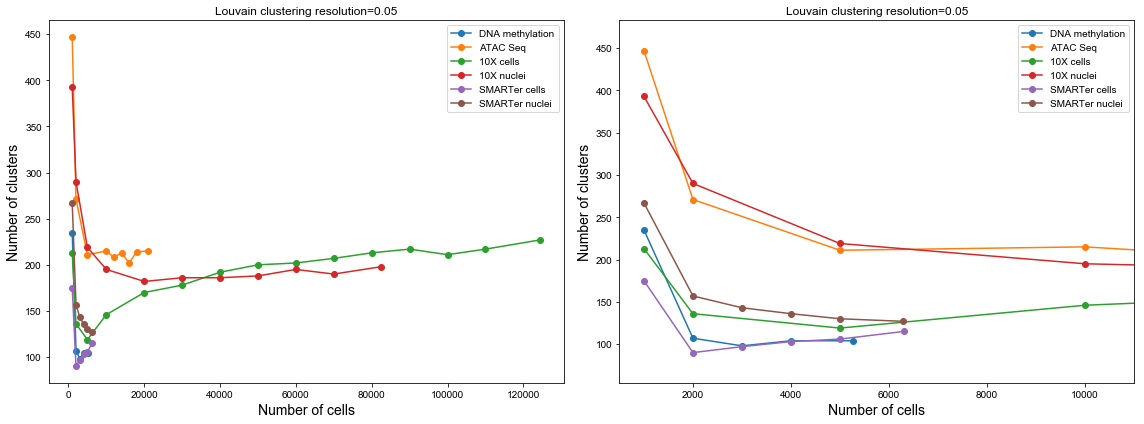

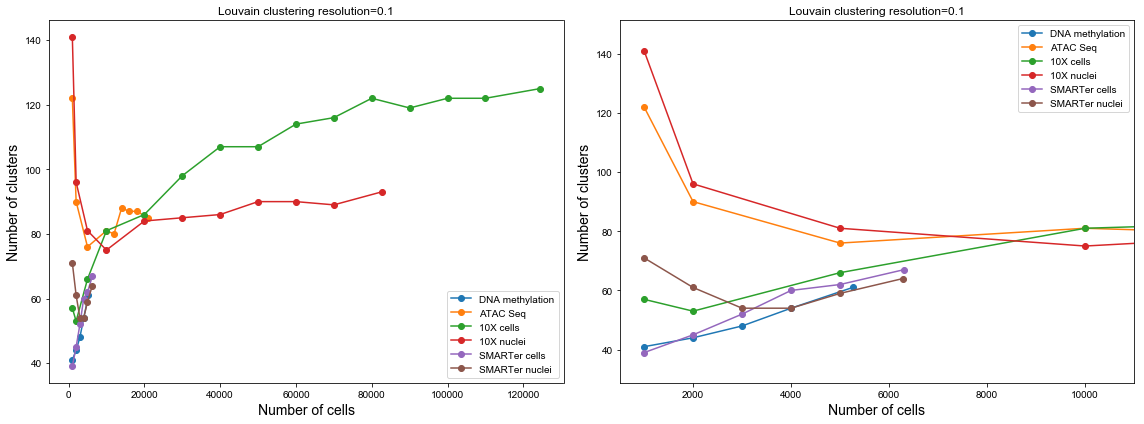

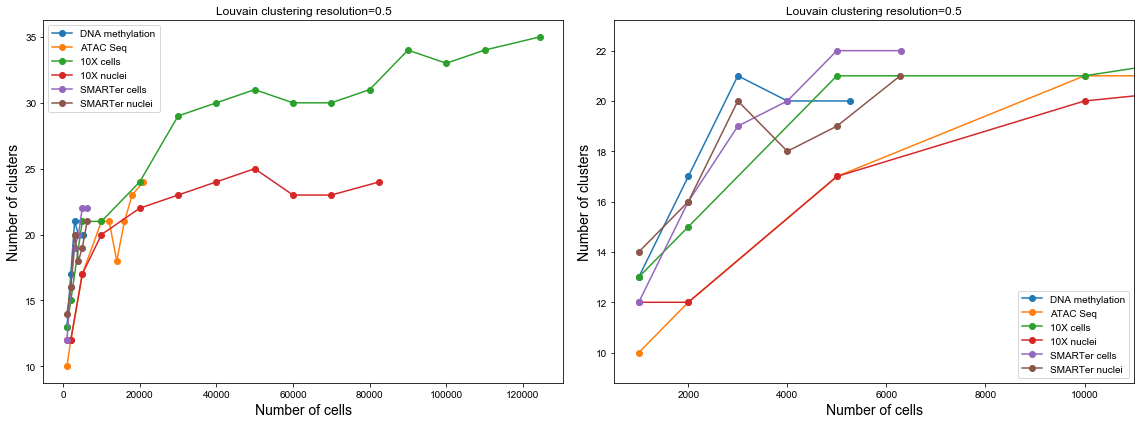

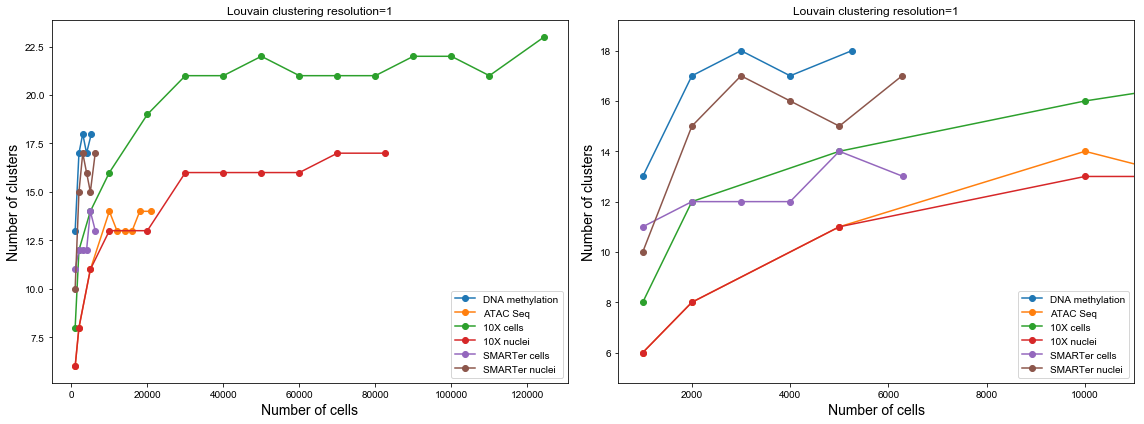

In [21]:
rvals = mod_rvals['snmcseq_gene']
# rval = 'k30'
for rval in rvals: 
    # mods_used = ['snmcseq_gene', 'snatac_gene', '10x_cells', ]
    mods_used = mods

    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    for i, ax in enumerate(axs):
        _tmp = []
        for mod in mods_used:
            _x = res1.loc[mod, :, rval]['nclst']
            ax.plot(_x.index.values, _x.values, '-o', 
                    label='{}'.format(settings[mod].name), 
                    color=settings[mod].color)
            _tmp += _x.iloc[_x.index.values<11000].values.tolist()

            ax.legend() 
        #     ax.set_xscale('log')
        #     ax.set_yscale('log')
            ax.set_xlabel('Number of cells', fontsize=14)
            ax.set_ylabel('Number of clusters', fontsize=14)
            ax.set_title("Louvain clustering resolution={}".format(rval))

        if i == 1:
            ax.set_xlim([500, 11000]) 
            ymin, ymax, yrange = min(_tmp), max(_tmp), max(_tmp) - min(_tmp)
            ymin, ymax = min(_tmp) - 0.1*yrange, max(_tmp) + 0.1*yrange
            ax.set_ylim([ymin, ymax]) 
    #         ax.set_ylim([15, 40]) 
    fig.tight_layout()
    plt.show()


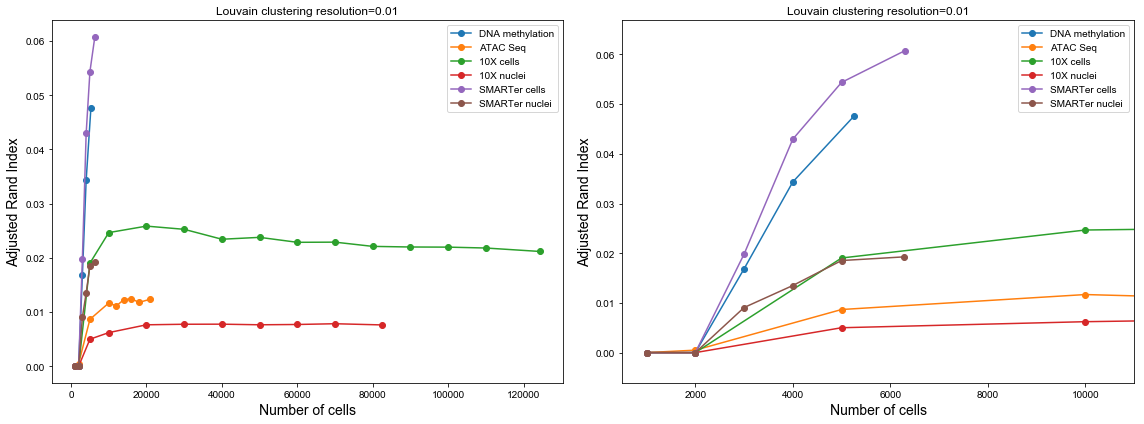

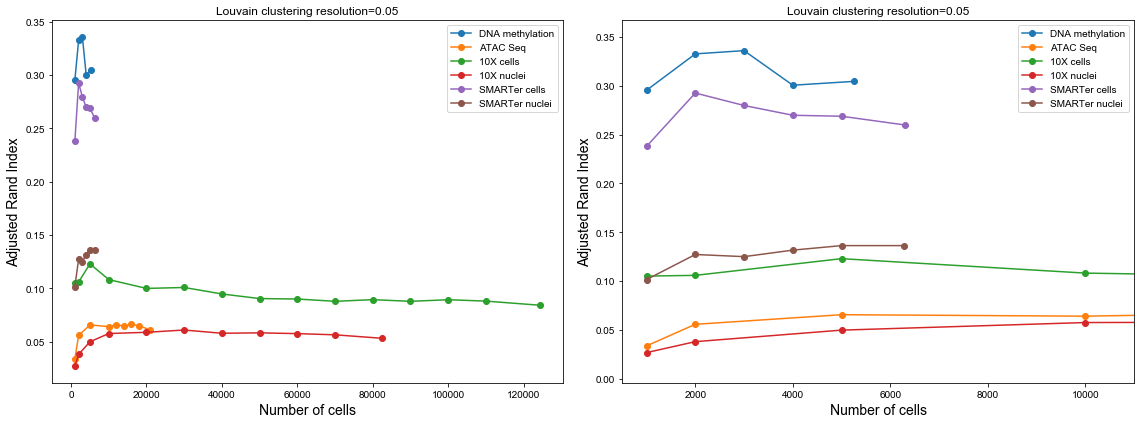

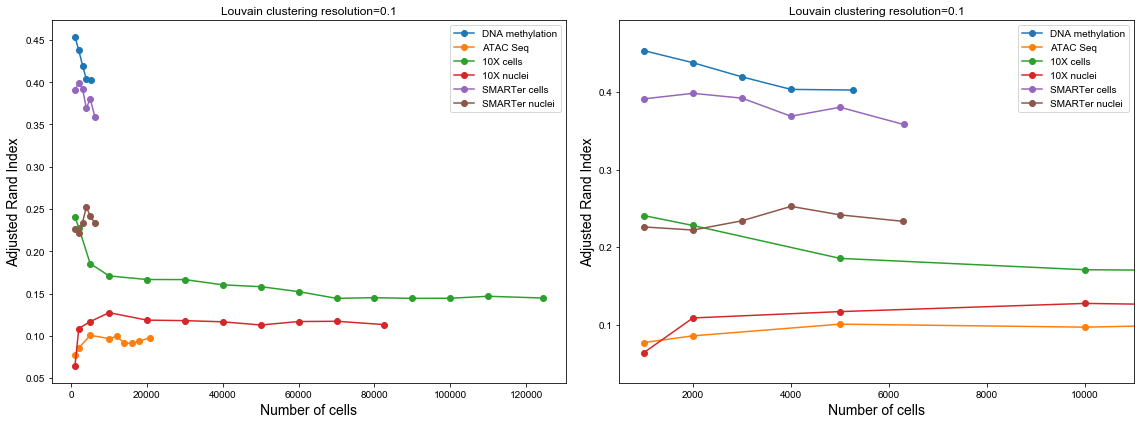

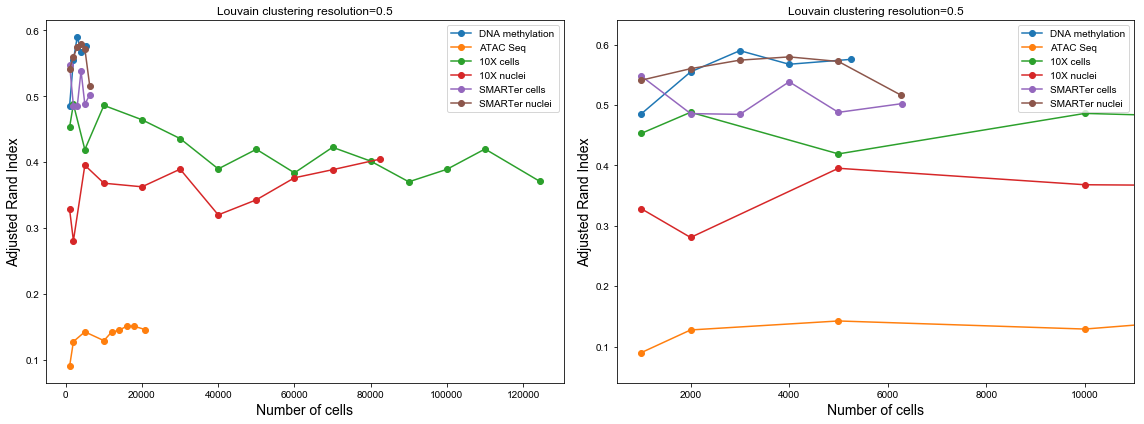

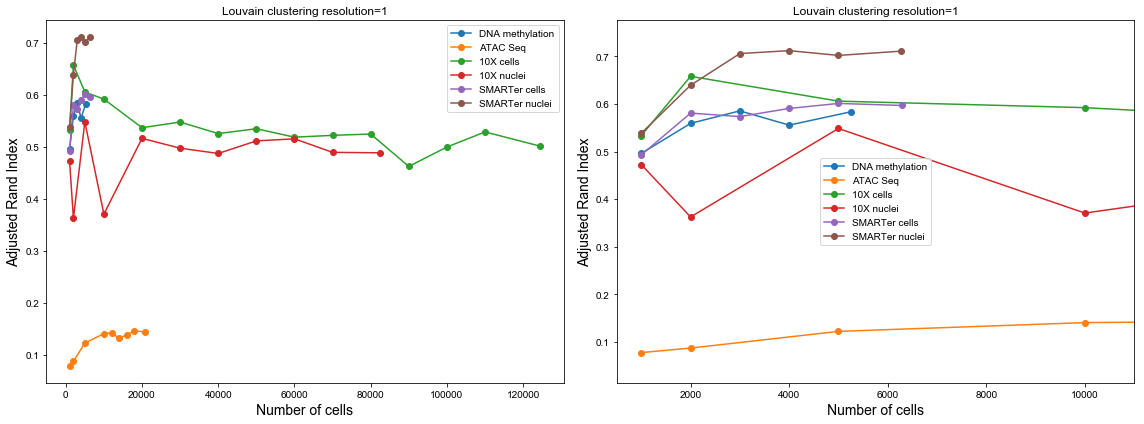

In [22]:
# 

rvals = mod_rvals['snmcseq_gene']
# rval = 'k30'
for rval in rvals: 
    # mods_used = ['snmcseq_gene', 'snatac_gene', '10x_cells', ]
    mods_used = mods

    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    for i, ax in enumerate(axs):
        _tmp = []
        for mod in mods_used:
            _x = res1.loc[mod, :, rval]['ari']
            ax.plot(_x.index.values, _x.values, '-o', 
                    label='{}'.format(settings[mod].name), 
                    color=settings[mod].color)
            _tmp += _x.iloc[_x.index.values<11000].values.tolist()

            ax.legend() 
        #     ax.set_xscale('log')
        #     ax.set_yscale('log')
            ax.set_xlabel('Number of cells', fontsize=14)
            ax.set_ylabel('Adjusted Rand Index', fontsize=14)
            ax.set_title("Louvain clustering resolution={}".format(rval))

        if i == 1:
            ax.set_xlim([500, 11000]) 
            ymin, ymax, yrange = min(_tmp), max(_tmp), max(_tmp) - min(_tmp)
            ymin, ymax = min(_tmp) - 0.1*yrange, max(_tmp) + 0.1*yrange
            ax.set_ylim([ymin, ymax]) 
    #         ax.set_ylim([15, 40]) 
    fig.tight_layout()
    plt.show()


### Visualization 4 - Phase diagram
- How to parameterize it

In [466]:
# errorbar 

res = [] 
mod_rvals = {}
mod_repeats = {}
mod_n_subs = {}
mod_ridxs = {}
mod_nidxs = {}

mods = MODS
prefix_format = '/cndd/fangming/CEMBA/results_neuron/clst_neuron_louvain_downsamp_{0}_'
#     files = natsorted(glob.glob('/cndd/fangming/CEMBA/results/clst_louvain_downsamp_{}_*_r*_0_v0'.format(mod)))
#     files = natsorted(glob.glob('/cndd/fangming/CEMBA/results/clst_louvain_downsamp_{}_*_*_0_v1'.format(mod)))

for mod in mods:
    files = natsorted(glob.glob(prefix_format.format(mod)+'*_*_0_v1'))
    rvals = set()
    n_subs = set()
    _repeats = set()

    for file in files:
        prefix = prefix_format.format(mod)
        n_sub, rval, _repeat, _version = file[len(prefix):].split('_')
        n_sub = int(n_sub)
        _repeat = int(_repeat)
        n_subs.add(n_sub)
        _repeats.add(_repeat)
#         rval = rval[1:] ### new
        rvals.add(rval)

        df_clst = pd.read_csv(file, sep='\t', index_col=0)
        if mod != 'integrated':
            y_pred = metas[mod].loc[df_clst.index, settings[mod].cluster_col].values
            y = df_clst['cluster'].values
            ari = adjusted_rand_score(y_pred, y)
        else:
            ari = 0
        
        nclst = len(df_clst['cluster'].unique())
        res.append({'mod': mod, 'rval': rval, 'n_sub': n_sub, 
                    'n_repeat': _repeat,
                    'nclst': nclst, 'clsts': df_clst, 'ari': ari,})
        
    rvals = np.sort(list(rvals))
    ridxs = np.arange(len(rvals))

    _repeats = np.sort(list(_repeats))
    n_subs = np.sort(list(n_subs))
    nidxs = np.arange(len(n_subs))
    
    mod_rvals[mod] = rvals
    mod_n_subs[mod] = n_subs
    mod_ridxs[mod] = ridxs
    mod_nidxs[mod] = nidxs
    mod_repeats[mod] = _repeats 
    
res = pd.DataFrame(res)
res.head()

,ari,clsts,mod,n_repeat,n_sub,nclst,rval
0,0.391604,...,snmcseq_gene,0,1000,108,0.075131
1,0.398851,...,snmcseq_gene,0,1000,92,0.082645
2,0.434006,...,snmcseq_gene,0,1000,70,0.090909
3,0.479915,...,snmcseq_gene,0,1000,50,0.100000
4,0.502728,...,snmcseq_gene,0,1000,42,0.110000


In [468]:
res1 = res.set_index(['mod', 'n_sub', 'rval'])
res1 = res1[res1['n_repeat']==0]
print(mod_rvals)
res1.head()

{'snmcseq_gene': array(['0.075131', '0.082645', '0.090909', '0.100000', '0.110000',
       '0.121000', '0.133100', '0.146410', '0.161051', '0.177156',
       '0.194872', '0.214359', '0.235795', '0.259374', '0.285312',
       '0.313843', '0.345227', '0.379750', '0.417725', '0.459497',
       '0.505447', '0.555992', '0.611591'], dtype='<U8'), 'snatac_gene': array(['0.075131', '0.082645', '0.090909', '0.100000', '0.110000',
       '0.121000', '0.133100', '0.146410', '0.161051', '0.177156',
       '0.194872', '0.214359', '0.235795', '0.259374', '0.285312',
       '0.313843', '0.345227', '0.379750', '0.417725', '0.459497',
       '0.505447', '0.555992', '0.611591'], dtype='<U8'), '10x_cells': array(['0.075131', '0.082645', '0.090909', '0.100000', '0.110000',
       '0.121000', '0.133100', '0.146410', '0.161051', '0.177156',
       '0.194872', '0.214359', '0.235795', '0.259374', '0.285312',
       '0.313843', '0.345227', '0.379750', '0.417725', '0.459497',
       '0.505447', '0.555992', '0.6

ari  \
mod          n_sub rval                 
snmcseq_gene 1000  0.075131  0.391604   
                   0.082645  0.398851   
                   0.090909  0.434006   
                   0.100000  0.479915   
                   0.110000  0.502728   

                                                                         clsts  \
mod          n_sub rval                                                          
snmcseq_gene 1000  0.075131                                                ...   
                   0.082645                                                ...   
                   0.090909                                                ...   
                   0.100000                                                ...   
                   0.110000                                                ...   

                             n_repeat  nclst  
mod          n_sub rval                       
snmcseq_gene 1000  0.075131         0    108  
                   0.082645         0     92  
                   0.090909         0     70  
                   0.100000         0     50  
                   0.110000         0     42

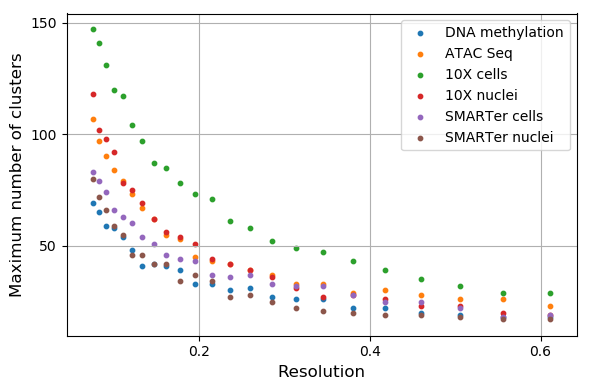

In [486]:
# 

mods_used = MODS[:-1] 
rvals = mod_rvals[mod]
n_repeats = 1

fig, ax = plt.subplots(1, 1, figsize=(6,4))
_tmp = []
colors = snmcseq_utils.get_grad_colors(len(rvals))

for mod in mods_used:
    _x = res1.loc[mod, mod_n_subs[mod][-1], :]
    ax.scatter(_x.index.values.astype(float), 
            _x['nclst'].values, 
            s=10,
            color=settings[mod].color,
            label=settings[mod].name)

ax.grid()
ax.locator_params(axis='both', tight=True, nbins=3)
ax.set_xlabel('Resolution', fontsize=12)
ax.set_ylabel('Maximum number of clusters', fontsize=12)
# ax.set_title("{}".format(settings[mod].name))
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.legend()

    
fig.tight_layout()
plt.show()


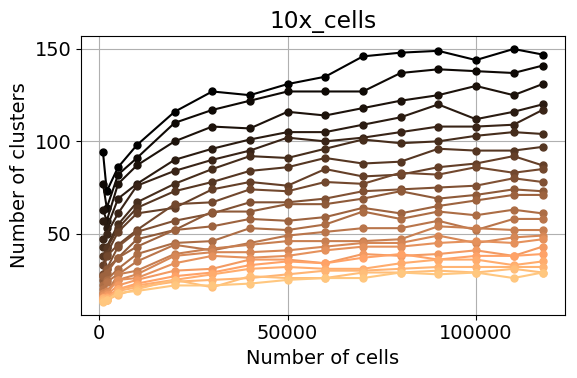

In [493]:
# plt.style.use('seaborn-whitegrid')
import matplotlib
font = {'size': 14}
matplotlib.rc('font', **font)

mod = '10x_cells'
rvals = mod_rvals[mod]
n_repeats = 1
# rval = 'k30'
# for rval in rvals: 
#     mods_used = mods

fig, ax = plt.subplots(1, 1, figsize=(6,4))
_tmp = []
colors = snmcseq_utils.get_grad_colors(len(rvals))

for i, rval in enumerate(rvals):
    label = '{}'.format(settings[mod].name)
#     color = settings[mod].color
    color = colors[i]
        
    _x = res1.loc[mod, :, rval]['nclst'].reset_index().groupby('n_sub').agg(['mean', 'std'])
    ax.errorbar(_x.index.values, 
                _x['nclst','mean'].values, 
                yerr=1.96*_x['nclst', 'std'].values/np.sqrt(n_repeats),
                label=label, 
                color=color,
                markersize=5,
                fmt='-o', 
                capsize=3,
               )
    _tmp += _x['nclst', 'mean'].iloc[_x.index.values<11000].values.tolist()

ax.grid()
ax.locator_params(axis='both', tight=True, nbins=3)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of clusters')
ax.set_title("{}".format(mod))
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

    
fig.tight_layout()
plt.show()


### Other plots

- how well clustering results agree with provided clustering results?

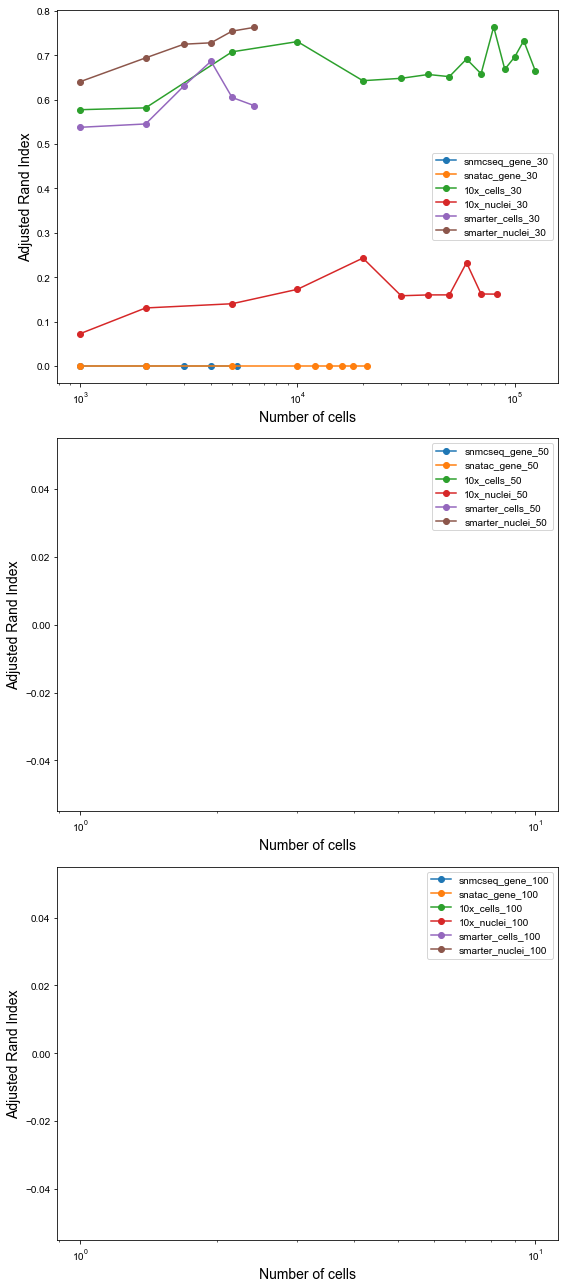

In [26]:
# 
fig, axs = plt.subplots(3, 1, figsize=(8,6*3))
for k, ax in zip(ks, axs):
    for mod in mods:
#         if mod == 'snmcseq_gene':
#             continue
        ax.plot(res_nsubs[(mod, k)], res_aris[(mod, k)], '-o', label='{}_{}'.format(mod, k), color=settings[mod].color)
    
    ax.legend() 
    ax.set_xscale('log')
    ax.set_xlabel('Number of cells', fontsize=14)
    ax.set_ylabel('Adjusted Rand Index', fontsize=14)
    
fig.tight_layout()
plt.show()

(124418, 1)
(124418, 13)


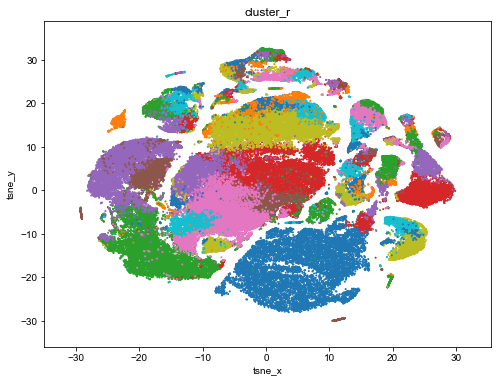

In [13]:
mod = '10x_cells'
k = 30
files = natsorted(glob.glob('/cndd/fangming/CEMBA/results/clst_iter_downsamp_{}_*_k{}_0_v2'.format(mod, k)))


df_clst = pd.read_csv(files[-1], sep='\t', header=0, index_col=0)
print(df_clst.shape)

df_plot = metas[mod].join(df_clst, lsuffix='_l', rsuffix='_r')
print(df_plot.shape)

snmcseq_utils.plot_tsne_labels(df_plot, tc='cluster_r', sample_n=10000, legend_mode=-1)

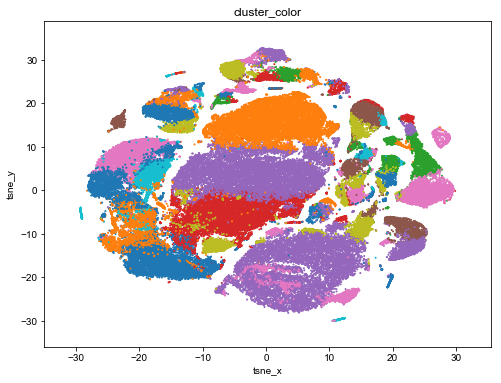

In [28]:
snmcseq_utils.plot_tsne_labels(df_plot, tc='cluster_color', sample_n=10000, legend_mode=-1)

## 10x case study 
- correlation of centroids
- tSNE of centroids

In [47]:
# clusters
mods_used = ['10x_cells', '10x_nuclei']
nsub = 70000
rval = '0.235795' 

files_key = {
    'mod': '10x_cells'
}
prefix_format = '/cndd/fangming/CEMBA/results_neuron/clst_neuron_louvain_downsamp_{0}_{1}_{2}_0_v1'

df_clsts = {}
for mod in mods_used:
    df_clsts[mod] = pd.read_csv(prefix_format.format(mod, nsub, rval), sep='\t', index_col=0)
    print(len(df_clsts[mod]['cluster'].unique()))

df_clsts[mod].head()

62
43


,cluster
sample,
GGGTTGCCAGACGTAG-8L8TX_180420_01_D01,0
TGAGCCGGTACTTAGC-8L8TX_180420_01_D01,0
ATCTGCCGTACGAAAT-7L8TX_180420_01_C01,0
ACTGATGAGAGCTGGT-2L8TX_180301_01_B06,0
TCAGCTCGTGGAAAGA-8L8TX_180420_01_D01,0


In [31]:
# generate cluster level features

clst_hvftrs = {}
for mod in mods_used:
    # 
    data = gxc_hvftrs[mod].data.tocsc()
    genes = gxc_hvftrs[mod].gene
    cells = gxc_hvftrs[mod].cell
    
    clst_hvftr = pd.DataFrame(index=genes)
    for clst, df_sub in df_clsts[mod].groupby('cluster'):
        # clst, cells
        cells_sub = df_sub.index.values
        # idx of cells
        cells_sub_idx = pd.Series(cells).reset_index().set_index(0).loc[cells_sub, 'index'].values
        # data 
        _x = data[:, cells_sub_idx].mean(axis=1)
        clst_hvftr[clst] = _x 
        
    clst_hvftrs[mod] = clst_hvftr
        
clst_hvftrs[mod].head() 

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Adhfe1,0.037996,0.006671,0.018903,0.018054,0.027408,0.016235,0.014770,0.038507,0.024692,0.039264,...,0.029205,0.023268,0.017046,0.013768,0.014554,0.037255,0.040637,0.023306,0.026263,0.051033
Gm29570,0.022439,0.026000,0.034816,0.021469,0.053143,0.018430,0.044892,0.060813,0.031970,0.047663,...,0.044876,0.037698,0.023311,0.026308,0.025971,0.046283,0.007004,0.020120,0.014393,0.012311
Gm973,0.020567,0.013744,0.028913,0.028845,0.031048,0.028517,0.036699,0.067086,0.037970,0.037787,...,0.023554,0.034836,0.030501,0.026485,0.029602,0.027970,0.027648,0.006814,0.023829,0.027975
Gm15668,0.034765,0.025868,0.035682,0.034071,0.042656,0.034679,0.033940,0.070968,0.031344,0.040849,...,0.040975,0.023867,0.027251,0.029215,0.011131,0.039380,0.006997,0.023656,0.025769,0.029110
Gm29114,0.018575,0.010095,0.014720,0.001934,0.006575,0.040157,0.016374,0.025376,0.045258,0.032936,...,0.019430,0.018040,0.013548,0.011104,0.011120,0.019988,0.006952,0.023626,0.054421,0.017991


In [213]:
def select_hvg(gbc_data, percentile=30):
    # further select highly variable genes
    # variance/mean
    mean_cpm, var_cpm = gbc_data.mean(axis=1), gbc_data.std(axis=1) 
    vmr_cpm = (var_cpm+1)/(mean_cpm+1)
    
    # select top 30 percentile vmr from each first 9 deciles of CPM
    _x = pd.qcut(pd.Series(mean_cpm), 10, labels=False).to_frame('decile')
    hvgs = []
    fig, ax = plt.subplots()
    for decile, _x_sub in _x.groupby('decile'):
        gene_group = _x_sub.index.values
        mean_cpm_gg = mean_cpm[gene_group]
        vmr_cpm_gg = vmr_cpm[gene_group]
        # genes with top 30% of vmr
        hvg_group = gene_group[vmr_cpm_gg > np.percentile(vmr_cpm_gg, 100-percentile)]

        if decile != 9:
            hvgs.append(hvg_group)
            ax.scatter(mean_cpm_gg, vmr_cpm_gg, s=1, c='black', alpha=0.5)
            ax.scatter(mean_cpm[hvg_group], vmr_cpm[hvg_group], s=2)

    hvgs = np.hstack(hvgs)

    plt.show()
    
    return hvgs


## Case study

```mod_x``` ```mod_y``` ```clst_hvftrs```

In [214]:
# correlation
mod_x, mod_y = '10x_cells', '10x_nuclei'
genes_common = np.intersect1d(clst_hvftrs[mod_x].index.values, 
                              clst_hvftrs[mod_y].index.values,
                             )
_x = clst_hvftrs[mod_x].loc[genes_common, :].T
_y = clst_hvftrs[mod_y].loc[genes_common, :].T

# select highly variable genes in common
hvg_x = _x.std(axis=0).sort_values(ascending=False).head(500).index.values
hvg_y = _y.std(axis=0).sort_values(ascending=False).head(500).index.values


# hvg_x = select_hvg(_x.T, percentile=20)
# hvg_y = select_hvg(_x.T, percentile=20)



genes_selected = np.intersect1d(hvg_x, hvg_y)
print(len(genes_selected))
_x = clst_hvftrs[mod_x].loc[genes_selected, :].T.rank(axis=1, pct=True)
_y = clst_hvftrs[mod_y].loc[genes_selected, :].T.rank(axis=1, pct=True)

print(_x.shape, _y.shape)
corr = np.corrcoef(_x, _y)[:len(_x), len(_x):] # row - x
corr = pd.DataFrame(corr, index=_x.index.values, columns=_y.index.values)
corr.index.name, corr.columns.name = mod_x, mod_y

331
(62, 331) (43, 331)


In [215]:
# get annot
clst_annots = {}
for mod in [mod_x, mod_y]: 
    clst_annots[mod] = (df_clsts[mod].join(metas[mod].drop(settings[mod].cluster_col, axis=1))
                                      .groupby('cluster')
                                      .agg(lambda x:x.value_counts(ascending=False).index[0]) # most common value
                                     [settings[mod].annot_col]
                                    .apply(lambda x: x.split('_')[0])
                        )

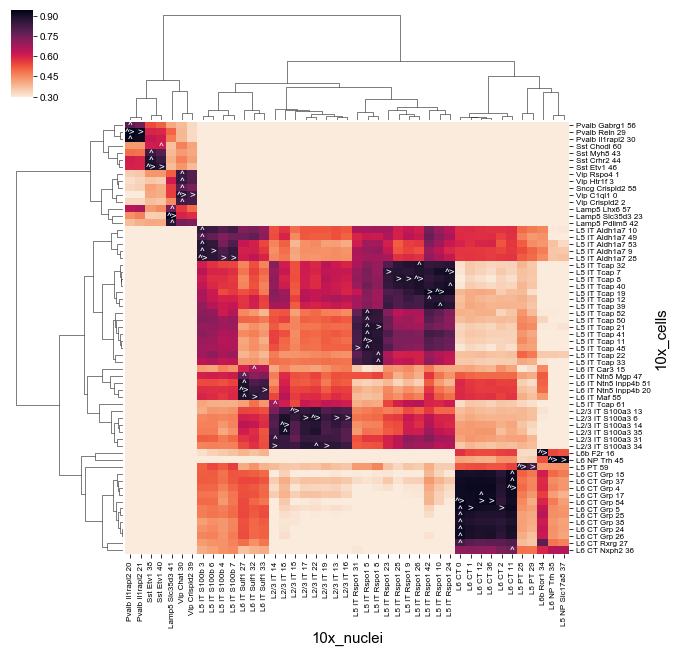

In [256]:
# for each row, get the best col
df_annot = pd.DataFrame(columns=corr.columns, index=corr.index)
for idx, col in corr.idxmax(axis=1).iteritems(): # for each row 
    df_annot.loc[idx, col] = '^'
df_annot = df_annot.fillna('')

# for each col, get the best row 
df_annot_row = pd.DataFrame(columns=corr.columns, index=corr.index)
for col, idx in corr.idxmax(axis=0).iteritems(): # for each col 
    df_annot_row.loc[idx, col] = '>'
df_annot_row = df_annot_row.fillna('')

df_annot = df_annot + df_annot_row


# draw cluster map, only to get the orders
g = sns.clustermap(corr, 
               annot=df_annot, 
               fmt='',
               cmap='rocket_r')
ordered_row = g.dendrogram_row.reordered_ind
ordered_col = g.dendrogram_col.reordered_ind
plt.close()

# draw cluster map
g = sns.clustermap(corr, 
               annot=df_annot.loc[ordered_row, ordered_col],  # they do not reorder for you
               annot_kws={"size": 10},
               fmt='',
               cmap='rocket_r', 
               xticklabels=['{} {}'.format(clst_annots[mod_y].loc[clst], clst) for clst in corr.columns.values], # they reorder for you
               yticklabels=['{} {}'.format(clst_annots[mod_x].loc[clst], clst) for clst in corr.index.values],
               vmin=0.3,
#                square=True,
            )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=8)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)
g.ax_heatmap.set_xlabel(g.ax_heatmap.get_xlabel(), fontsize=15)
g.ax_heatmap.set_ylabel(g.ax_heatmap.get_ylabel(), fontsize=15)

plt.show()

## Marker genes 

In [345]:
# marker genes 
mod_clsts = {'10x_cells': [23, 42, 57],
             '10x_nuclei': [41],
            }

mod_clsts_comp = {}
for mod in [mod_x, mod_y]:
    mod_clsts_comp[mod] = clst_hvftrs[mod].loc[genes_common, mod_clsts[mod]].copy()

In [ ]:
mod 

In [253]:
# a list of marker genes
marker_genes = ['Lamp5', 'Slc35d3', 'Lhx6', 'Pdlim5']

# cell level visualization - gene by cell matrix

In [266]:
# valid marker genes
for mod in [mod_x, mod_y]:
    res = np.any([True if marker_gene in gxc_raws[mod].gene else False for marker_gene in marker_genes])
    print(res)

True
True


In [279]:
# select genes and cells

mats = {}

for mod in [mod_x, mod_y]:
    ti = time.time()
    
    _x = df_clsts[mod][df_clsts[mod]['cluster'].isin(mod_clsts[mod])]
    cells_selected = _x.index.values
    print(_x.groupby('cluster').size(), len(cells_selected))
    
    # select from raw matrix
    marker_gene_idxs = pd.Series(gxc_raws[mod].gene).reset_index().set_index(0).loc[marker_genes, 'index'].values
    cells_selected_idxs = pd.Series(gxc_raws[mod].cell).reset_index().set_index(0).loc[cells_selected, 'index'].values
    
    _mat = gxc_raws[mod].data.tocsr()[marker_gene_idxs, :].tocsc()[:, cells_selected_idxs].todense()
    print(time.time() - ti)
    
    mats[mod] = pd.DataFrame(_mat, index=marker_genes, columns=cells_selected) 
    print(time.time() - ti)
    

cluster
23    1995
42    1322
57     299
dtype: int64 3616
23.990689754486084
23.992214918136597
cluster
41    1119
dtype: int64 1119
2.2080812454223633
2.2086966037750244


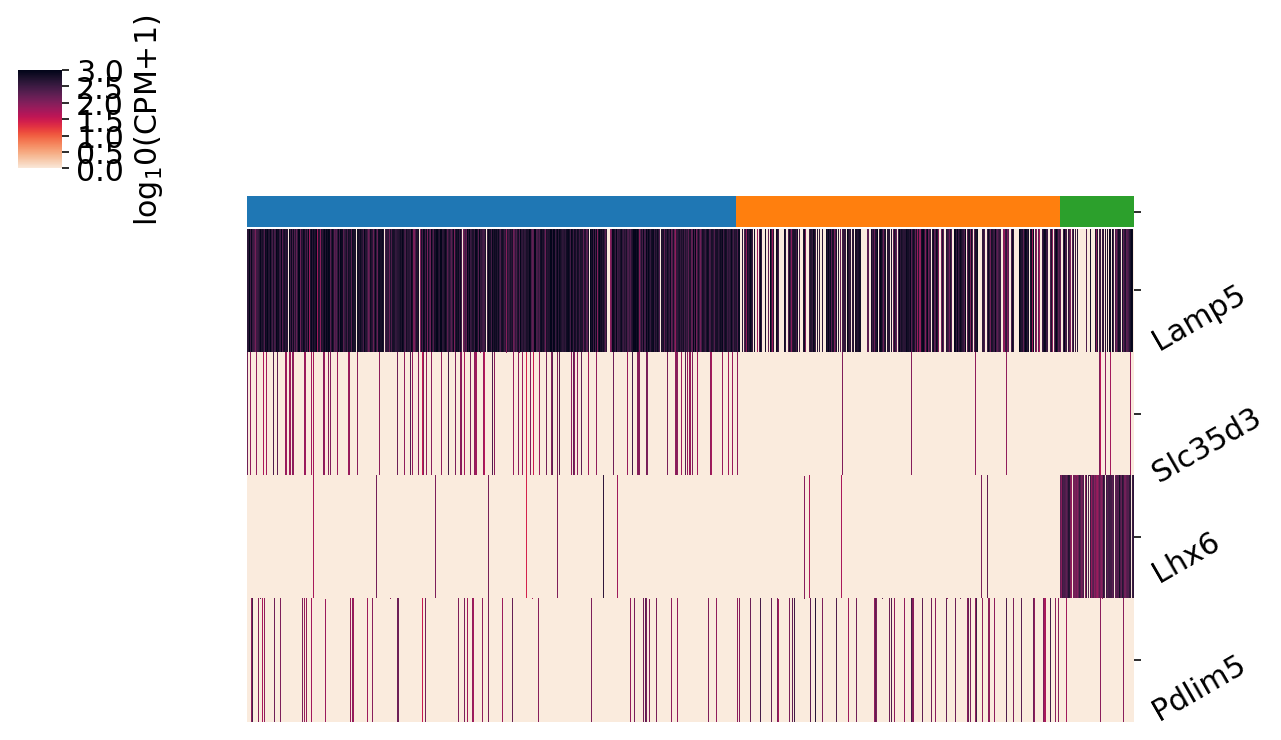

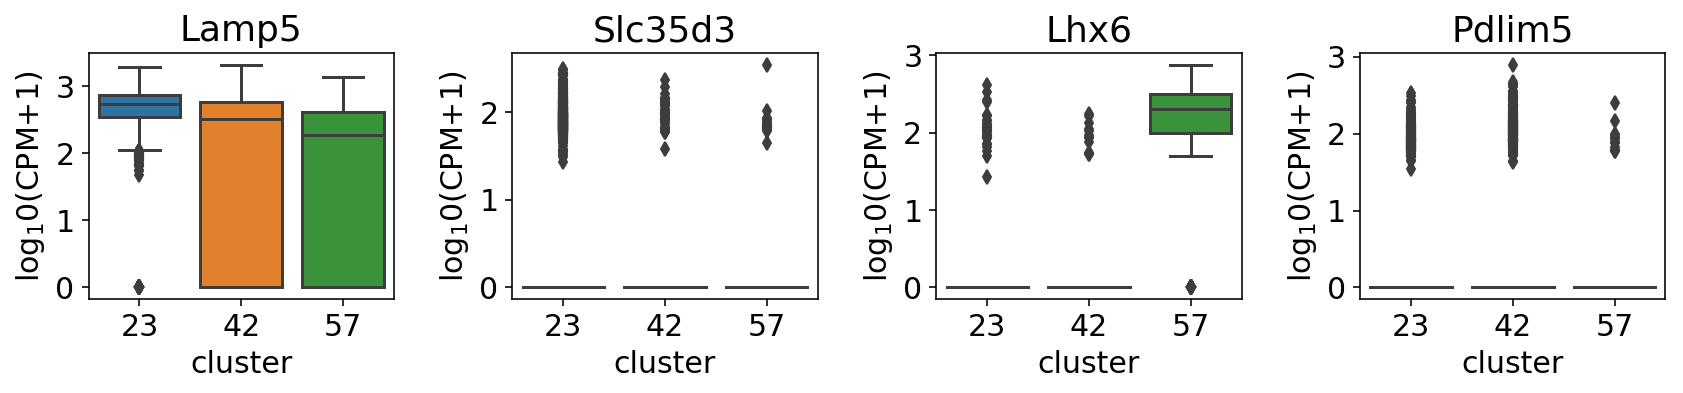

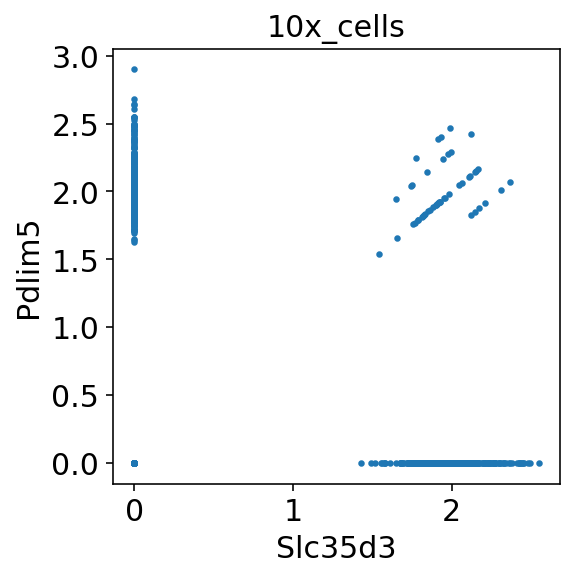

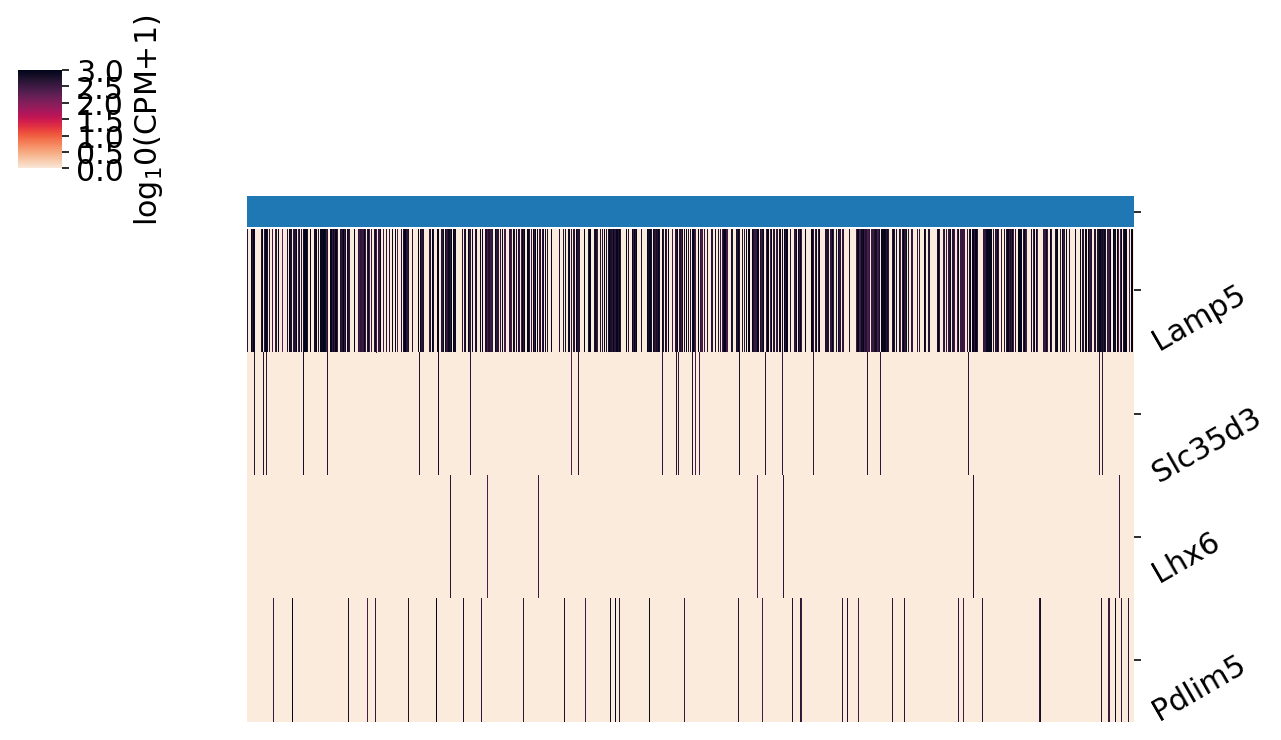

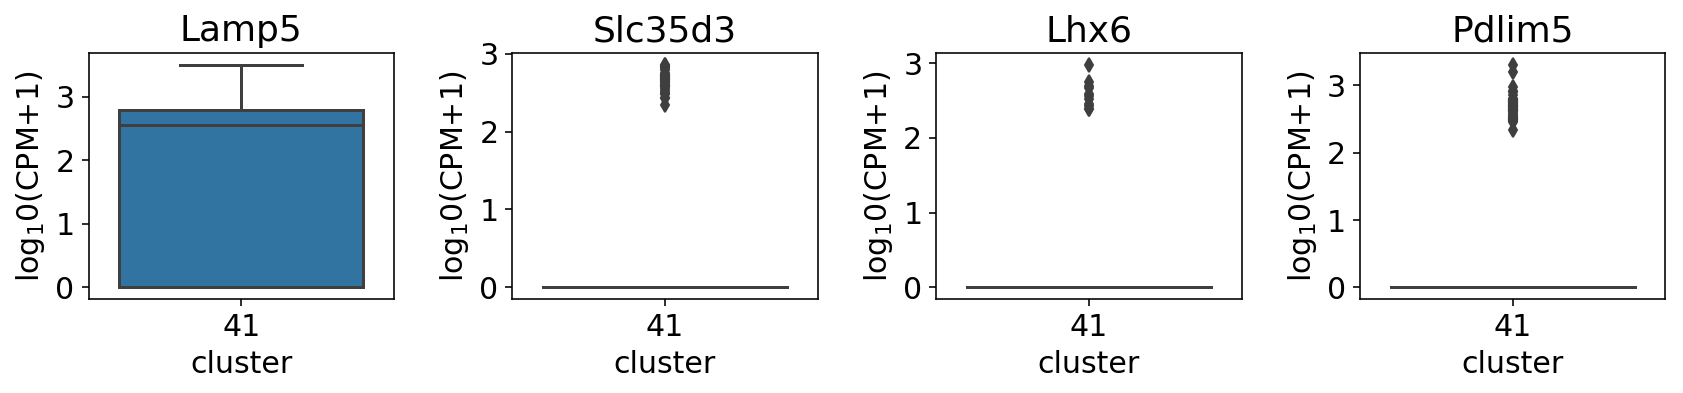

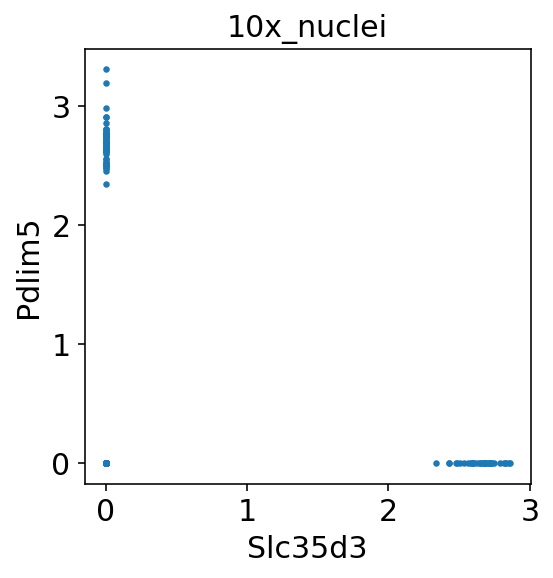

In [520]:
# heatmaps, boxplot on CPM
for mod in [mod_x, mod_y]:
    
    _x = df_clsts[mod][df_clsts[mod]['cluster'].isin(mod_clsts[mod])]
    _x = _x.sort_values('cluster')
    
    colors = {}
    for i, clst in enumerate(_x['cluster'].unique()):
        colors[clst] = 'C{}'.format(i)
    
    cells_selected = _x.index.values
    
    _mat = mats[mod][cells_selected].divide(metas[mod].loc[cells_selected, settings[mod].total_reads], axis=1)
    _mat = np.log10(_mat*1e6+1) #.apply(stats.zscore, axis=1)
    g = sns.clustermap(_mat, 
                row_cluster=False, 
                col_cluster=False,
                col_colors=pd.Series([colors[clst] for clst in _x['cluster'].values], index=_x.index.values),
                xticklabels=False,
                yticklabels=True,
                cmap='rocket_r', 
                cbar_kws={'label': r'$\log_10$(CPM+1)'},
                figsize=(10,6),
                vmax=3,
                )
#     g.ax_heatmap.set_title(mod_x, fontsize=15)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=30)
    plt.show()
    
    

    _x = _x.join(_mat.T)
    marker_gene = marker_genes[0]
    n = len(marker_genes)
    fig, axs = plt.subplots(1, n, figsize=(3*n, 3*1))
    for marker_gene, ax in zip(marker_genes, axs):
        sns.boxplot(x='cluster', y=marker_gene, data=_x, ax=ax)
#         sns.violinplot(x='cluster', y=marker_gene, data=_x, ax=ax)
        ax.set_ylabel(r'$\log_10$(CPM+1)')
        ax.set_title(marker_gene)
    fig.tight_layout()
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(_mat.loc['Slc35d3'].values, 
               _mat.loc['Pdlim5'].values,
               s=5,
              )
    ax.set_xlabel('Slc35d3', fontsize=15)
    ax.set_ylabel('Pdlim5', fontsize=15)
    ax.set_title(mod, fontsize=15)
    plt.show()
    
